# Trabajo Práctico 1: Propiedades en Venta

### Grupo 08

Ciriani, Chiara
Danko, Tomás
Guglielmi, Nicolás
Magnani, Elian
Shih, Ian

## Importación de Librerías

Importamos librerías generales

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Importamos librerías de modelos

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score,cross_validate

Importamos librería de métricas

In [44]:
#Metricas para evaluar modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# 1. Análisis Exploratorio y Preprocesamiento de Datos

Importamos dataset

In [45]:
dataset = pd.read_csv("properati_argentina_2021.csv")

In [46]:
dataset.shape

(460154, 20)

Filtramos los anuncios por el tipo de vivienda (Casa, PH y Departamente), ubicados en Capital Federal cuyo tipo de operacion sea venta y su precio se encuentre en dolares.

In [47]:
cond_property_types = dataset['property_type'].isin(['Casa', 'PH', 'Departamento'])
cond_operation = dataset['operation'] == 'Venta'
cond_price_currency = dataset['property_currency'] == 'USD'
cond_location = dataset['place_l2'] == 'Capital Federal'

dataset = dataset[cond_property_types & cond_operation & cond_price_currency & cond_location]

Luego, separamos en un conjunto de entrenamiento (80%) y un conjunto de test (20%)

In [48]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=2)

## a) Exploración Inicial

Listamos la cantidad de filas y columnas que tiene el dataset

In [49]:
dataset.shape

(94249, 20)

Este dataset contenía originalmente 460154 filas y 20 columnas, de las que quedaron 94249 filas y 20 columnas después del filtrado.

Listamos los nombres de las columnas del dataset

In [50]:
dataset_train.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Descripción de los campos

- id: identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.

- start_date: fecha de alta del aviso.

- end_date: fecha de baja del aviso.

- created_on: fecha de alta de la primera versión del aviso.

- latitud: latitud.

- longitud: longitud.

- place: campos referidos a la ubicación de la propiedad o del desarrollo.
	- l1 - Nivel administrativo 1: país.
	- l2 - Nivel administrativo 2: usualmente provincia.
	- l3 - Nivel administrativo 3: usualmente ciudad.
	- l4 - Nivel administrativo 4: usualmente barrio.

- operation: tipo de operación (Venta, Alquiler).

- property_type: tipo de aviso (Propiedad, Desarrollo/Proyecto).

- property_rooms: cantidad de ambientes (útil en Argentina).

- property_bedrooms: cantidad de dormitorios (útil en el resto de los países).

- property_surface_total: superficie total en m².

- property_surface_covered: superficie cubierta en m².

- property_price: precio publicado en el anuncio.

- property_currency: moneda del precio publicado.

- property_title: título del anuncio

Se decide cambiar los nombres de las columnas place_l2, place_l3 y place_l4 para lograr una mejor representación del dominio

In [51]:
columns_to_rename = {"place_l2":"city", "place_l3":"neighborhood", "place_l4":"zone"}
dataset_train.rename(columns = columns_to_rename, inplace = True)

dataset_train.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'city',
 'neighborhood',
 'zone',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Tipo de Variable

In [52]:
dataset_train.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
city                         object
neighborhood                 object
zone                         object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

### Variables Cuantitativas

Calcular medidas de resumen: media, mediana, q1, q3, moda.

In [53]:
dataset_train.describe()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,72416.000000,72416.000000,0.0,74559.000000,66550.000000,71515.00000,72759.000000,7.539900e+04
mean,-34.591125,-58.450693,NaN,2.822798,2.015567,112.53916,90.110213,2.273315e+05
std,0.189522,0.304372,NaN,1.429959,1.133740,1088.20166,1106.636675,3.256379e+05
min,-53.788624,-71.439510,NaN,1.000000,-1.000000,10.00000,1.000000,5.000000e+03
25%,-34.615979,-58.466523,NaN,2.000000,1.000000,45.00000,40.000000,9.500000e+04
50%,-34.595749,-58.439042,NaN,3.000000,2.000000,65.00000,57.000000,1.440000e+05
75%,-34.577395,-58.408935,NaN,4.000000,3.000000,105.00000,89.000000,2.350000e+05
max,-24.219827,-54.133330,NaN,40.000000,70.000000,137000.00000,217000.000000,2.140000e+07


### Variables Cualitativas

Mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [54]:
qualitative_dataset = dataset_train.select_dtypes(exclude=np.number)
new_columns = qualitative_dataset.columns.to_list()
unwanted_columns = ['id', 'start_date', 'end_date', 'created_on', 'property_title']
new_columns = [e for e in new_columns if e not in unwanted_columns]

for column in new_columns:
    print(column)
    print(f"Cantidad de valores posibles: {qualitative_dataset[column].nunique()}")
    print(qualitative_dataset[column].value_counts())
    print()


city
Cantidad de valores posibles: 1
Capital Federal    75399
Name: city, dtype: int64

neighborhood
Cantidad de valores posibles: 57
Palermo                 11517
Belgrano                 7092
Caballito                5727
Recoleta                 4992
Villa Urquiza            3759
Almagro                  3279
Nuñez                    2791
Villa Crespo             2518
Flores                   2500
Barrio Norte             2367
Balvanera                2046
Colegiales               1564
Villa Devoto             1544
Villa del Parque         1490
Saavedra                 1470
Puerto Madero            1210
San Telmo                1086
San Cristobal            1050
Barracas                 1010
San Nicolás              1008
Retiro                   1001
Boedo                     981
Floresta                  951
Monserrat                 899
Parque Chacabuco          840
Villa Pueyrredón          803
Coghlan                   792
Villa Luro                577
Chacarita                 

### Variables Irrelevantes

A partir del análisis se decide eliminar los campos de IDs (ya que se percibe irrelevante para el tratamiento que se está haciendo de los datos), Property Currency (porque luego del filtrado solo se listarán propiedades en USDs), City (debido a que post filtrado solo quedan propiedades de Capital Federal) y Operation (solo hay propiedades en venta).

In [55]:
ds_cropped = dataset_train.drop(['id', 'property_currency', 'city', 'operation'], axis='columns')
ds_cropped.columns.tolist()

['start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'neighborhood',
 'zone',
 'place_l5',
 'place_l6',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_title']

### Análisis gráfico de las distribuciones de las variables

En esta parte se realizan gráficos para analizar las distribuciones de las variables. Se graficarán por separado las variables cualitativas (discretas) y cuantitativas (continuas). Asimismo, se dejaran afuera ciertas variables como las coordenadas, fechas y titulos debido a que no aportan información en este análisis.

Al visualizar los gráficos se pueden observar ciertos detalles como por ejemplo la presencia de outliers y tendencias.

In [56]:
colors=["red", "blue", "orange", "green", "purple", "gray"]

In [57]:
ds_cropped.head(5)

,start_date,end_date,created_on,latitud,longitud,neighborhood,zone,place_l5,place_l6,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,NaN,NaN,NaN,Departamento,2.0,1.0,65.0,53.0,198000.0,1 - Holmberg 2700
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,NaN,NaN,NaN,Departamento,1.0,NaN,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...
211207,2021-11-16,2021-11-18,2021-11-16,NaN,NaN,Caballito,NaN,NaN,NaN,Departamento,2.0,1.0,41.0,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,NaN,NaN,NaN,Departamento,1.0,1.0,49.0,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,NaN,NaN,NaN,Departamento,1.0,2.0,NaN,78.0,290000.0,Departamento en Palermo


Variables Discretas

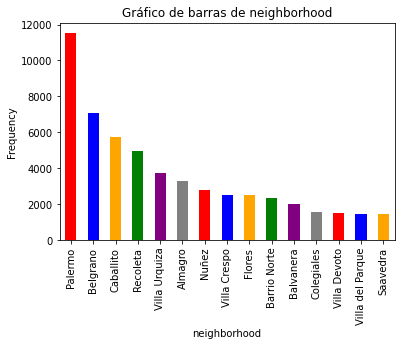

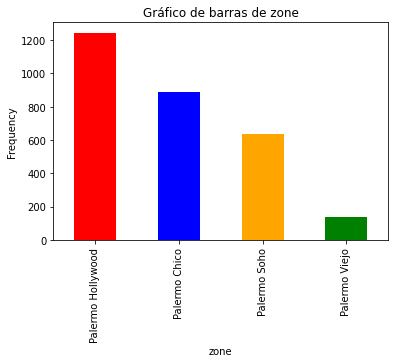

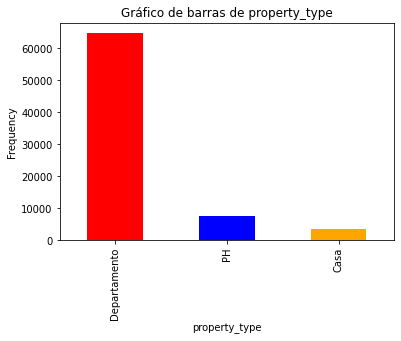

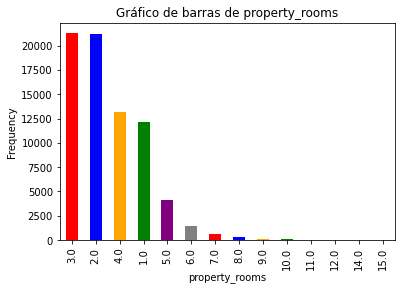

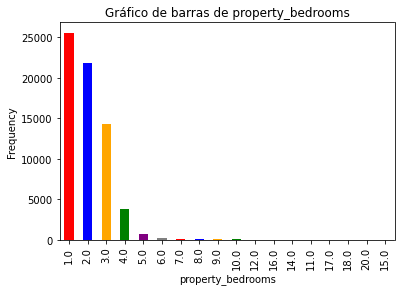

In [58]:
wanted_discreet_variables = ['neighborhood', 'zone', 'property_type', 'property_rooms', 'property_bedrooms']

for variable in wanted_discreet_variables:
    title = f"Gráfico de barras de " + variable
    counted_values = ds_cropped[variable].value_counts()
    if len(counted_values) > 15:
        counted_values[:15].plot.bar(color=colors, title=title, xlabel=variable,ylabel="Frequency")
    else:
        counted_values.plot.bar(color=colors, title=title, xlabel=variable,ylabel="Frequency")
    plt.show()


Variables Continuas

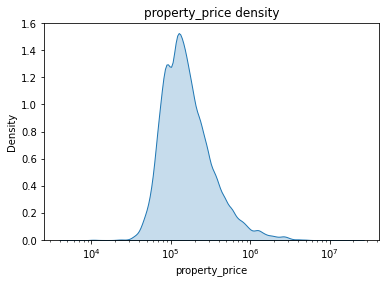

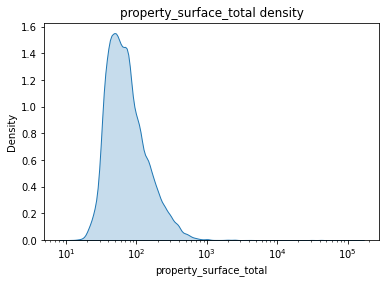

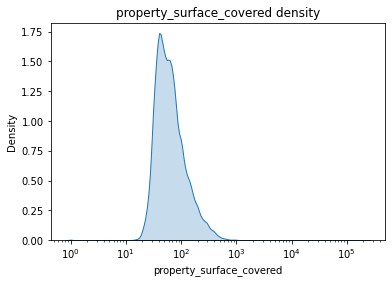

In [59]:
wanted_continuous_variables = ['property_price', 'property_surface_total', 'property_surface_covered']

for variable in wanted_continuous_variables:
    sns.kdeplot(data=ds_cropped[variable], log_scale=(10), fill=True).set(title=f"{variable} density", xlabel=variable, ylabel="Density")
    plt.show()

### Correlaciones existentes entre variables

Para analizar la correlación entre variables procedemos a realizar un heatmap usando el método de correlación de Pearson (mide su correlación lineal con el coeficiente de correlación r) que mientras más cerca de 1, indica mayor correlación lineal positiva, y mientras más cerca de -1 mayor correlación lineal negativa.

Es importante para este análisis elegir un método de conversión de variables categóricas para que puedan ser medidas con el resto. Para este caso, nosotros elegimos One Hot Encoding y dejamos de lado las variables "barrio" y "zona" ya que al tener 57 y 4 valores posibles respectivamente, el heatmap pierde legibilidad.

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_7892\465094372.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_dummies.corr(method='pearson'), annot=True, cmap="YlGnBu")


<AxesSubplot:>

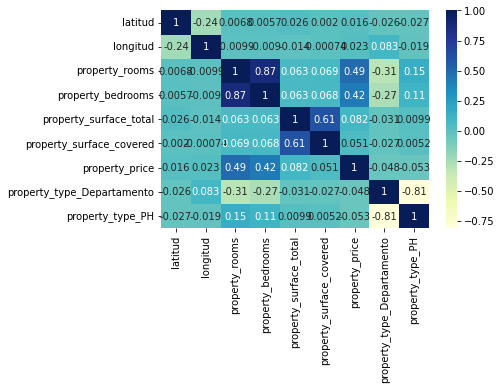

In [60]:
df_dummies = pd.get_dummies(ds_cropped, columns=['property_type'], drop_first=True).drop("place_l6", axis=1)
sns.heatmap(df_dummies.corr(method='pearson'), annot=True, cmap="YlGnBu")

## Conclusiones de la Exploración Inicial

Este primer acercamiento al entendimiento del set de datos con el cual se está trabajando ha sido de vital importancia para tomar ciertas decisiones que agilizan el procesamiento del gran volumen de información que se dispone. Ha de notarse que gracias a esto, se pudo purgar el dataset de todo aquello que se considera irrelevante para nuestro objetivo y se ha podido comprender mucho mejor las características del mismo (ya sea el tipo de variables que intervienen como también lo que representa cada una).

De ahora en adelante se pretende seguir trabajando con los datos purificados de manera un poco mas clara y efectiva.

## b) Datos Faltantes

Si bien no se pide, es útil analizar los datos duplicados ya que dependiendo del dataset, a veces tenemos información duplicada que no queremos. Luego, si alertamos una fila duplicada, la eliminamos. Esto lo podemos hacer gracias a que contamos con las columnas "latitud" y "longitud". Si se detecta que dos propiedades no solo tienen todas sus características iguales si no también idénticas coordenadas, entonces consideramos que es una propiedad duplicada.

In [61]:
size_antes = len(ds_cropped)
ds_cropped = ds_cropped.drop_duplicates()
size_despues = len(ds_cropped)
print(f'Se eliminaron: {size_antes-size_despues} filas duplicadas')

Se eliminaron: 819 filas duplicadas


Los valores nulos pueden tener distintas formas de ser representados:

- Nan

- Vacíos ""

- Algún caracter especial "_", "?", "NULL"

- Valores que no tienen sentido dado la variable (ejemplo: distancia recorrida: -1)

Vamos a analizar el dataset general

In [62]:
tienen_caracter_raro = ds_cropped.astype('str').eq('-').any(0)
tienen_caracter_raro

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_7892\4116890165.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  tienen_caracter_raro = ds_cropped.astype('str').eq('-').any(0)


start_date                  False
end_date                    False
created_on                  False
latitud                     False
longitud                    False
neighborhood                False
zone                        False
place_l5                    False
place_l6                    False
property_type               False
property_rooms              False
property_bedrooms           False
property_surface_total      False
property_surface_covered    False
property_price              False
property_title              False
dtype: bool

Chequemos variables numéricas

In [63]:
quantitative_dataset = ds_cropped.select_dtypes(include=np.number)
quantitative_columns = quantitative_dataset.columns
(dataset[quantitative_columns] <= 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
latitud,True
longitud,True
place_l6,False
property_rooms,False
property_bedrooms,True
property_surface_total,False
property_surface_covered,False
property_price,False


Mientras que las variables 'latitud' y ' longitud' tienen sentido que sean menores a 0, no es el caso de la variable 'property_bedrooms' ya que no se puede tener habitaciones negativas en una propiedad. Después exploraremos opciones para manejar este caso sin sentido.

Revisamos si las variables numéricas son decimales:

In [64]:
quantitative_dataset = ds_cropped.select_dtypes(include=np.float)
quantitative_columns = quantitative_dataset.columns
(dataset[quantitative_columns]).any().to_frame('Variables decimales ?')

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_7892\56666754.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  quantitative_dataset = ds_cropped.select_dtypes(include=np.float)


,Variables decimales ?
latitud,True
longitud,True
place_l6,False
property_rooms,True
property_bedrooms,True
property_surface_total,True
property_surface_covered,True
property_price,True


Tienen sentido que esas variables sean decimales salvo por las variables 'property_rooms' y 'property_bedrooms' ya que no se puede tener, por ejemplo, 2.5 habitaciones en una propiedad. Esto puede ser debido a un error de tipeo, como por ejemplo eran 5 habitaciones y se tipeó 0.5 o directamente es un error. Después exploraremos opciones para manejar este caso sin sentido.

Porcentaje de datos nulos por columna

In [65]:
print(ds_cropped.isna().sum()/len(ds_cropped)*100)

start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.907214
longitud                      3.907214
neighborhood                  0.457227
zone                         96.141057
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.107536
property_bedrooms            11.680075
property_surface_total        5.143470
property_surface_covered      3.506302
property_price                0.000000
property_title                0.000000
dtype: float64


<AxesSubplot:>

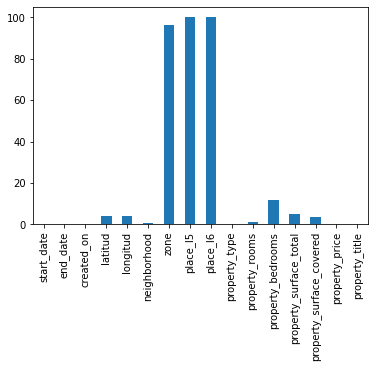

In [66]:
missing_data_series_by_column = ds_cropped.isna().sum()/len(ds_cropped) * 100
missing_data_series_by_column.plot.bar(x='columnas', y='porcentaje de datos faltantes')

In [67]:
# comento esto porque tarda mucho

#missing_data_series_by_row = (ds_cropped.isna().sum(axis = 1) / ds_cropped.shape[1] * 100).reset_index(drop = True)
#missing_data_series_by_row.plot.bar(x='filas', y='porcentaje de datos faltantes')

### Estrategias para reparar los valores faltantes

Una vez analizados los datos, tenemos que tomar desiciones sobre qué hacer con los datos faltantes

Opción 0: Eliminarlos del dataset

In [68]:
dataset_eliminar_nans=ds_cropped.copy()

# columnas_eliminar_NANs=['neighborhood','place_l5','place_l6']
columnas_eliminar_NANs=['neighborhood']
dataset_eliminar_nans.drop(columnas_eliminar_NANs, axis='columns', inplace=True)

filas_totales=dataset_eliminar_nans.shape[0]
print(dataset_eliminar_nans.isna().sum()/filas_totales*100)

start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.907214
longitud                      3.907214
zone                         96.141057
place_l5                    100.000000
place_l6                    100.000000
property_type                 0.000000
property_rooms                1.107536
property_bedrooms            11.680075
property_surface_total        5.143470
property_surface_covered      3.506302
property_price                0.000000
property_title                0.000000
dtype: float64


Eliminamos el resto de las filas con Nans

In [69]:
dataset_eliminar_nans.dropna(inplace=True)

print(f"cantidad de registros originales: {ds_cropped.shape[0]}")
print(f"cantidad de registros finals: {dataset_eliminar_nans.shape[0]}")

porcentaje=(ds_cropped.shape[0]-dataset_eliminar_nans.shape[0])/ds_cropped.shape[0]*100

print(f"Eliminamos el {porcentaje}% de los registros")

cantidad de registros originales: 74580
cantidad de registros finals: 0
Eliminamos el 100.0% de los registros


Opción 1: Tratarla como una "categoría" o valor más

En este caso, tratamos como si valor None fuese categoría nueva, es decir, cambiamos por constante

In [70]:
dataset_eliminar_nans_op1=ds_cropped.copy()

Por ejemplo, los que le falta atributo 'property_bedrooms' le ponemos a todos lo que falta 99 

In [71]:
dataset_eliminar_nans_op1['property_bedrooms'] = dataset_eliminar_nans_op1['property_bedrooms'].fillna(99)

Otro ejemplo es a lo que les falta el atributo 'neighborhood' le ponemos a todos  'Ciudad no existe'

In [72]:
dataset_eliminar_nans_op1['neighborhood'] = dataset_eliminar_nans_op1['neighborhood'].fillna("Ciudad no existe")

Opción 2: completar usando info de esa columna (Univariadas)

La idea es completar con la mediana, promedio, moda o constante

In [73]:
dataset_eliminar_nans_op2=ds_cropped.copy()

In [74]:
# Devuelve el valor de imputacion de las tres estrategias para esa columna

def show_strategies(df, name_col, k=99):
    _df = df[[name_col]].copy()
    s = df[name_col]

    _df['mediana'] = s.fillna(s.median())
    _df['media'] = s.fillna(s.mean())
    _df['moda'] = s.fillna(s.mode()[0])
    _df['constante'] = k

    return _df[s.isna()]

show_strategies(dataset_eliminar_nans_op2, 'property_bedrooms',99)

,property_bedrooms,mediana,media,moda,constante
27438,NaN,2.0,2.016427,1.0,99
155007,NaN,2.0,2.016427,1.0,99
163967,NaN,2.0,2.016427,1.0,99
310141,NaN,2.0,2.016427,1.0,99
137226,NaN,2.0,2.016427,1.0,99
...,...,...,...,...,...
373821,NaN,2.0,2.016427,1.0,99
298297,NaN,2.0,2.016427,1.0,99
255850,NaN,2.0,2.016427,1.0,99
212476,NaN,2.0,2.016427,1.0,99


Opción 3: completar usando info de las demas columnas (Multivariada)

In [75]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

columnas=['property_surface_total','property_surface_covered','property_bedrooms']
dataset_eliminar_nans_op3=ds_cropped[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0) #imputation_order='roman'
dataset_eliminar_nans_op3_completo=imp.fit_transform(dataset_eliminar_nans_op3)

In [76]:
dataset_eliminar_nans_op3_completo

array([[ 65.        ,  53.        ,   1.        ],
       [ 29.        ,  29.        ,   2.00883219],
       [ 41.        ,  35.        ,   1.        ],
       ...,
       [ 52.        ,  45.        ,   1.        ],
       [123.        ,  71.        ,   2.        ],
       [ 50.        ,  10.74199592,   1.        ]])

Existen otras opciones que no haremos pero valen la pena mencionar:

Opción 4: Imputación Cold Deck
Selecciona valores o usa relaciones obtenidas de fuentes distintas de la base de datos actual

Opción 5: Imputación Hot Deck
Se reemplazan los faltantes con valores obtenidos de registros que son los más similares.

Opción 6: Imputación por regresión
El dato faltante es reemplazado con el valor predicho por un modelo de regresión

Opción 7: MICE - Multivariate Imputation by Chained Equations
Trabaja bajo el supuesto de que el origen de los faltantes es Missing At Random (MAR).
Es un proceso de imputación de datos faltantes iterativo, en el cual, en cada iteración cada valor faltante de cada variable se predice en función de las variables restantes.
Esta iteración se repite hasta que se encuentre convergencia en los valores.
Por lo general 10 iteraciones es suficiente.
(En cada iteración genera un dataset)

Una vez analizadas todas las opciones, procedemos a eliminar los valores faltantes:

Debido a que las columnas 'place_l5' y 'place_l6' tienen el 100% de datos nulos, creemos que es mejor directamente eliminar ambas columnas. Si bien 'zone' no tiene el 100%, creemos que 96% es un porcentaje bastante alto y también la vamos a eliminar.

In [77]:
ds_cropped_without_nans=ds_cropped.copy()

columnas_eliminar_NANs=['zone','place_l5','place_l6']
ds_cropped_without_nans.drop(columnas_eliminar_NANs, axis='columns', inplace=True)

filas_totales=ds_cropped_without_nans.shape[0]
print(ds_cropped_without_nans.isna().sum()/filas_totales*100)

start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      3.907214
longitud                     3.907214
neighborhood                 0.457227
property_type                0.000000
property_rooms               1.107536
property_bedrooms           11.680075
property_surface_total       5.143470
property_surface_covered     3.506302
property_price               0.000000
property_title               0.000000
dtype: float64


Todavía quedan columnas con porcentaje de datos nulos. Para los valores nulos restantes se reemplazará por la media

In [78]:
ds_cropped_without_nans = ds_cropped_without_nans.fillna(ds_cropped_without_nans.mean())

filas_totales=ds_cropped_without_nans.shape[0]
print(ds_cropped_without_nans.isna().sum()/filas_totales*100)

start_date                  0.000000
end_date                    0.000000
created_on                  0.000000
latitud                     0.000000
longitud                    0.000000
neighborhood                0.457227
property_type               0.000000
property_rooms              0.000000
property_bedrooms           0.000000
property_surface_total      0.000000
property_surface_covered    0.000000
property_price              0.000000
property_title              0.000000
dtype: float64


C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_7892\2964241603.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ds_cropped_without_nans = ds_cropped_without_nans.fillna(ds_cropped_without_nans.mean())


Podemos observar que para este entonces, la única categoría que todavía posee valores faltantes es la de neighbourhood. Esto se debe a que es una categoría con valores cualitativos, que no pueden ser imputados utilizando la media. Para este caso en particular usaremos la técnica Hot Deck que reemplaza los faltantes con valores obtenidos de registros que son los más similares. Para esto, debemos definir esos registros "más similares", y como estamos hablando de neighbourhoods, lo más lógico es decir que aquellas propiedades con valores cercanos en latitud y en longitud a la que posee un valor faltante se puede considerar similar.

Realizo los mismos cambios hechos en el dataset de training para el dataset de test:

In [79]:
dataset_test.rename(columns = columns_to_rename, inplace = True)
dataset_test.drop(['id', 'property_currency', 'city', 'operation'], axis='columns')
dataset_test = dataset_test.drop_duplicates()
dataset_test.drop(columnas_eliminar_NANs, axis='columns', inplace=True)
dataset_test = dataset_test.fillna(dataset_test.mean())

C:\Users\Ian Shih\AppData\Local\Temp\ipykernel_7892\2344353561.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_test = dataset_test.fillna(dataset_test.mean())


Se realizaron imputaciones para las siguientes categorías:

## c) Valores Atípicos

### Análisis univariado

Mediante el análisis de los gráficos de tipo Box-Plot vamos a intentar identificar outliers univariados.

1. Variable 'property_rooms'

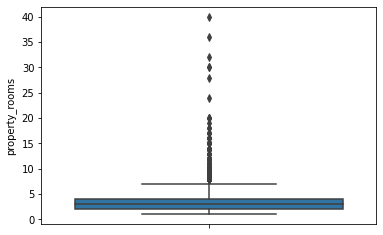

In [80]:
sns.boxplot(y=ds_cropped_without_nans.property_rooms)
plt.show()

In [81]:
#Cuartiles
Q1_property_rooms=np.quantile(ds_cropped_without_nans.property_rooms,0.25)
Q3_property_rooms=np.quantile(ds_cropped_without_nans.property_rooms,0.75)

#Rango intercuartil
IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

#Limite inferior Outliers
out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print(out_inf)
print(out_sup)

-1.0
7.0


Encontramos que existen outliers univariados en la variable 'property_rooms'. Verificamos que no se trata de un valor posible y procedemos a eliminarlo. En este caso, consideramos que es extraño que una propiedad contenga más de 20 habitaciones.

In [82]:
#Observación anómala
ds_cropped_without_nans_and_anomalies = ds_cropped_without_nans.copy()
outliers=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_rooms']>20]
outliers

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
52157,2021-02-07,2021-06-15,2021-02-07,-34.649872,-58.483012,Parque Avellaneda,PH,30.0,2.0,72.0,60.000000,123500.0,PH - Parque Avellaneda
90004,2021-08-03,9999-12-31,2021-08-03,-34.633236,-58.480313,Floresta,PH,32.0,32.0,535.0,435.000000,300000.0,"Hotel Familiar, 32 Habitaciones"
356618,2021-11-18,2021-12-02,2021-11-18,-34.588742,-58.422459,Palermo,Departamento,40.0,3.0,75.0,68.000000,145000.0,SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...
21009,2021-03-15,2021-06-05,2021-03-15,-34.616391,-58.456038,Caballito,Departamento,30.0,2.0,79.0,79.000000,230000.0,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito
147916,2021-08-19,9999-12-31,2021-08-19,-34.591166,-58.450646,Tribunales,Departamento,36.0,18.0,1348.0,90.303995,1700000.0,Departamento - Tribunales
292167,2021-02-23,2021-03-03,2021-02-23,-34.616487,-58.371596,San Telmo,PH,24.0,22.0,800.0,650.000000,350000.0,Antiguo Ph para Hotel de Pasajeros 650m2
389282,2021-05-05,2021-06-05,2021-05-05,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.000000,950000.0,Imponente casa inglesa de 3 plantas S.S. en ...


In [83]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_rooms']>20].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

Visualicemos nuevamente el Box-Plot

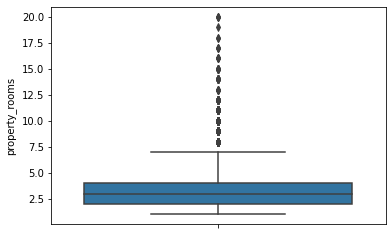

In [84]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_rooms)
plt.show()

DUDAAAAA: DEBERÍAMOS CONSIDERAR TODO LO QUE SEA MAYOR A 7.5 OUTLIER? OSEA SI ES UNA MANSION ES NORMAL CAPAZ QUE TENGA 15 NI IDEA NO TENGO UNA MANSION

ALSO TO DO: validar en valores faltatntes de sacar las property_rooms y property_bedrooms de sacar los decimales porque no tiene sentido tener mitad habitación

2. Variable 'property_bedrooms'

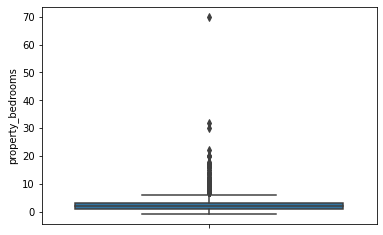

In [85]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_bedrooms)
plt.show()

In [86]:
#Cuartiles
Q1_property_bedrooms=np.quantile(ds_cropped_without_nans_and_anomalies.property_bedrooms,0.25)
Q3_property_bedrooms=np.quantile(ds_cropped_without_nans_and_anomalies.property_bedrooms,0.75)

#Rango intercuartil
IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

#Limite inferior Outliers
out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print(out_inf)
print(out_sup)

-2.0
6.0


Encontramos que existen outliers univariados en la variable 'property_bedrooms'. Verificamos que no se trata de un valor posible y procedemos a eliminarlo. En este caso, consideramos que es extraño que una propiedad contenga más de 10 dormitorios.

In [87]:
outliers=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_bedrooms']>10]
outliers

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
362676,2021-01-16,2021-08-06,2021-01-16,-34.618485,-58.377993,San Telmo,Casa,16.000000,16.0,112.256728,943.0,1300000.0,Casa en San Telmo
173300,2021-05-11,2021-09-16,2021-05-11,-34.631117,-58.382757,Constitución,Casa,14.000000,12.0,466.000000,436.0,390000.0,CASA EN VENTA 14 AMB. CONSTITUCIÓN PATIO TERRAZA
183941,2021-05-23,2022-02-09,2021-05-23,-34.618541,-58.391789,San Cristobal,PH,8.000000,12.0,513.000000,446.0,410000.0,VENTA EDIFICIO PH 3 PLANTAS P/SUBDIVIDIR O REM...
36421,2021-09-21,2022-02-03,2021-09-21,-34.576061,-58.421289,Palermo,Departamento,3.000000,20.0,127.000000,117.0,650000.0,Departamento - Palermo
354668,2021-03-31,2021-04-16,2021-03-31,-34.611905,-58.382384,Monserrat,PH,15.000000,16.0,587.000000,276.0,349000.0,PH DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...
337147,2021-04-13,2021-06-05,2021-04-13,-34.591166,-58.450646,Almagro,Departamento,3.000000,20.0,111.000000,76.0,245000.0,Excelente y único Departamento en duplex a nue...
396876,2021-02-13,2021-04-13,2021-02-13,-34.604062,-58.405112,Once,Departamento,14.000000,12.0,301.000000,179.0,220000.0,Venta Departamento 12 Ambientes
84296,2021-02-05,2021-02-05,2021-02-05,-34.604498,-58.385295,San Nicolás,Departamento,12.000000,12.0,237.000000,209.0,146000.0,DEPARTAMENTO A REFACCIONAR · TALCAHUANO AL 300...
118501,2021-02-04,2021-09-07,2021-02-04,-34.623056,-58.400937,San Cristobal,Casa,2.825976,12.0,632.000000,432.0,470000.0,"IMPORTANTE CASA DE 10 AMBIENTES CON PATIO , TE..."
367648,2021-04-10,2021-05-12,2021-04-10,-34.624204,-58.383089,Constitución,PH,14.000000,12.0,250.000000,200.0,199998.0,PH - Constitución


In [88]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['property_bedrooms']>10].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

Visualicemos nuevamente el Box-Plot

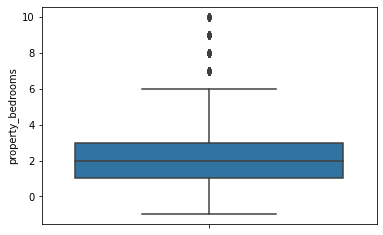

In [89]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_bedrooms)
plt.show()

Ahora probemos lás técnicas z-score y z-score modificado para las variables en el dataset

In [90]:
#z-score property_rooms
media_property_rooms=np.mean(ds_cropped_without_nans_and_anomalies.property_rooms)
std_property_rooms=np.std(ds_cropped_without_nans_and_anomalies.property_rooms)
ds_cropped_without_nans_and_anomalies['z_property_rooms']=(ds_cropped_without_nans_and_anomalies.property_rooms - media_property_rooms)/std_property_rooms

#z-score property_bedrooms
media_property_bedrooms=np.mean(ds_cropped_without_nans_and_anomalies.property_bedrooms)
std_property_bedrooms=np.std(ds_cropped_without_nans_and_anomalies.property_bedrooms)
ds_cropped_without_nans_and_anomalies['z_property_bedrooms']=(ds_cropped_without_nans_and_anomalies.property_bedrooms - media_property_bedrooms)/std_property_bedrooms

In [91]:
#z-score modificado property_rooms
mediana_property_rooms=np.median(ds_cropped_without_nans_and_anomalies.property_rooms)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_rooms-mediana_property_rooms))

ds_cropped_without_nans_and_anomalies['zm_property_rooms']=(ds_cropped_without_nans_and_anomalies.property_rooms - mediana_property_rooms)*0.6745/MAD

#z-score modificado property_bedrooms
mediana_property_bedrooms=np.median(ds_cropped_without_nans_and_anomalies.property_bedrooms)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_bedrooms-mediana_property_bedrooms))

ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']=(ds_cropped_without_nans_and_anomalies.property_bedrooms - mediana_property_bedrooms)*0.6745/MAD

In [92]:
ds_cropped_without_nans_and_anomalies.head()

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,65.000000,53.0,198000.0,1 - Holmberg 2700,-0.597690,-1.037612,-0.6745,-0.67450
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.327588,0.009443,-1.3490,0.01108
211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-0.597690,-1.037612,-0.6745,-0.67450
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,Departamento,1.0,1.000000,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,-1.327588,-1.037612,-1.3490,-0.67450
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,Departamento,1.0,2.000000,112.256728,78.0,290000.0,Departamento en Palermo,-1.327588,-0.007479,-1.3490,0.00000


Verificamos si se cumple la regla de oro para la variable property_rooms:

In [93]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']>3]

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
317557,2021-09-29,2022-01-27,2021-09-29,-34.633152,-58.410014,Parque Patricios,Casa,7.0,4.0,185.000000,150.0,305000.0,Dúplex en Venta Parque Patricios. Se acepta De...,3.051796,2.052788,2.6980,1.3490
358714,2021-06-29,2021-08-10,2021-06-29,-34.590923,-58.384214,Recoleta,Departamento,9.0,4.0,668.000000,668.0,5000000.0,"VENTA impresionante PISO muy ALTO 668,62 m2 co...",4.511591,2.052788,4.0470,1.3490
237432,2021-02-27,2021-05-12,2021-02-27,-34.596541,-58.394830,Recoleta,PH,7.0,4.0,310.000000,200.0,450000.0,OPORTUNIDAD PH 310m²,3.051796,2.052788,2.6980,1.3490
338930,2021-06-01,2021-06-05,2021-06-01,-34.565930,-58.483281,Villa Urquiza,Casa,10.0,4.0,294.000000,279.0,550000.0,Casa - Villa Urquiza,5.241488,2.052788,4.7215,1.3490
152911,2021-12-09,2021-12-17,2021-12-09,-34.581400,-58.482716,Villa Urquiza,Casa,7.0,4.0,112.256728,200.0,300000.0,Casa - Urquiza R,3.051796,2.052788,2.6980,1.3490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88590,2021-05-14,2021-08-06,2021-05-14,-34.552565,-58.479308,Saavedra,Casa,8.0,4.0,353.000000,328.0,680000.0,EXCELENTE CASA EN VENTA EN EL BARRIO DE SAAVEDRA,3.781694,2.052788,3.3725,1.3490
203282,2021-05-10,2021-06-05,2021-05-10,-34.569861,-58.444716,Belgrano,PH,12.0,9.0,711.000000,711.0,525000.0,Av. Federico Lacroze 2400,6.701283,7.203455,6.0705,4.7215
70107,2021-09-23,2022-01-27,2021-09-23,-34.588758,-58.388796,Recoleta,Departamento,10.0,5.0,477.000000,400.0,1800000.0,Departamento - Recoleta,5.241488,3.082921,4.7215,2.0235
395051,2021-02-13,2021-03-01,2021-02-13,-34.622091,-58.508864,Monte Castro,Casa,8.0,6.0,360.000000,282.0,420000.0,Venta Casa 8 ambientes con garaje y Jardin,3.781694,4.113055,3.3725,2.6980


In [94]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']<-3]

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms


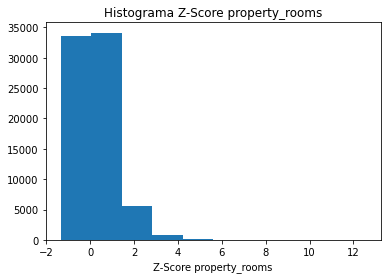

In [95]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_rooms)
plt.title('Histograma Z-Score property_rooms')
plt.xlabel('Z-Score property_rooms')
plt.show()

In [96]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=copy_ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_rooms']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

NameError: name 'copy_ds_cropped_without_nans_and_anomalies' is not defined

In [ ]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_rooms']>3.5)]

,property_rooms,property_bedrooms,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
358714,9.0,4.0,4.511591,2.052788,4.0470,1.3490
338930,10.0,4.0,5.241488,2.052788,4.7215,1.3490
138393,9.0,4.0,4.511591,2.052788,4.0470,1.3490
152772,10.0,5.0,5.241488,3.082921,4.7215,2.0235
451439,10.0,9.0,5.241488,7.203455,4.7215,4.7215
...,...,...,...,...,...,...
382881,9.0,4.0,4.511591,2.052788,4.0470,1.3490
314588,9.0,3.0,4.511591,1.022655,4.0470,0.6745
70959,11.0,5.0,5.971385,3.082921,5.3960,2.0235
203282,12.0,9.0,6.701283,7.203455,6.0705,4.7215


In [ ]:
copy_ds_cropped_without_nans_and_anomalies[(copy_ds_cropped_without_nans_and_anomalies['zm_property_rooms']<3.5)]

,property_rooms,property_bedrooms,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
256070,2.0,1.000000,-0.597690,-1.037612,-0.6745,-0.67450
27438,1.0,2.016427,-1.327588,0.009443,-1.3490,0.01108
211207,2.0,1.000000,-0.597690,-1.037612,-0.6745,-0.67450
228948,1.0,1.000000,-1.327588,-1.037612,-1.3490,-0.67450
361800,1.0,2.000000,-1.327588,-0.007479,-1.3490,0.00000
...,...,...,...,...,...,...
415279,2.0,1.000000,-0.597690,-1.037612,-0.6745,-0.67450
149099,2.0,1.000000,-0.597690,-1.037612,-0.6745,-0.67450
217366,2.0,1.000000,-0.597690,-1.037612,-0.6745,-0.67450
356023,3.0,2.000000,0.132207,-0.007479,0.0000,0.00000


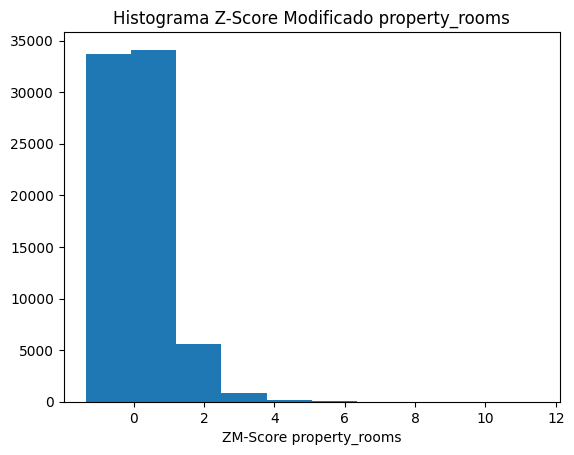

In [ ]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_rooms)
plt.title('Histograma Z-Score Modificado property_rooms')
plt.xlabel('ZM-Score property_rooms')
plt.show()

In [ ]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_rooms']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_rooms']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

Hacemos lo mismo para la variable 'property_bedrooms' :

In [ ]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']>3]

,property_rooms,property_bedrooms,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
307877,5.000000,5.0,1.592002,3.082921,1.349000,2.0235
6871,2.825976,7.0,0.005187,5.143188,-0.117379,3.3725
33026,7.000000,6.0,3.051796,4.113055,2.698000,2.6980
322063,7.000000,6.0,3.051796,4.113055,2.698000,2.6980
338774,7.000000,7.0,3.051796,5.143188,2.698000,3.3725
...,...,...,...,...,...,...
452275,4.000000,5.0,0.862104,3.082921,0.674500,2.0235
17172,5.000000,5.0,1.592002,3.082921,1.349000,2.0235
141135,6.000000,5.0,2.321899,3.082921,2.023500,2.0235
321630,5.000000,5.0,1.592002,3.082921,1.349000,2.0235


In [97]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']<-3]

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
406880,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Villa Urquiza,Departamento,2.0,-1.0,61.0,43.0,125000.0,Jardines de Roosevelt - Hermoso 3 ambientes co...,-0.59769,-3.097879,-0.6745,-2.0235


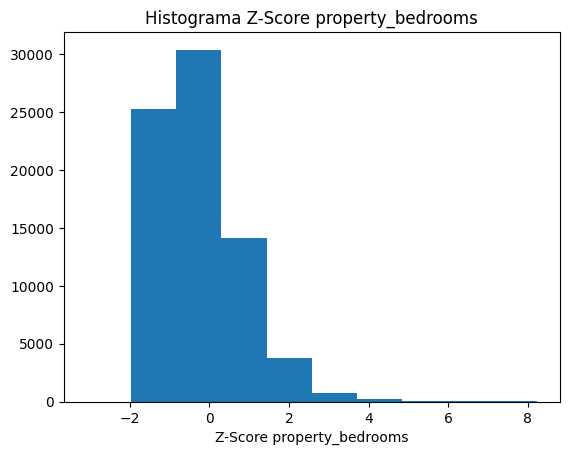

In [ ]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_bedrooms)
plt.title('Histograma Z-Score property_bedrooms')
plt.xlabel('Z-Score property_bedrooms')
plt.show()

In [ ]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_bedrooms']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[copy_ds_cropped_without_nans_and_anomalies['z_property_bedrooms']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

In [ ]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']>3.5)]

,property_rooms,property_bedrooms,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms
451439,10.000000,9.0,5.241488,7.203455,4.721500,4.7215
340919,2.825976,10.0,0.005187,8.233588,-0.117379,5.3960
366641,11.000000,8.0,5.971385,6.173322,5.396000,4.0470
85968,11.000000,10.0,5.971385,8.233588,5.396000,5.3960
112840,2.825976,10.0,0.005187,8.233588,-0.117379,5.3960
...,...,...,...,...,...,...
263173,8.000000,8.0,3.781694,6.173322,3.372500,4.0470
195609,11.000000,9.0,5.971385,7.203455,5.396000,4.7215
459922,10.000000,9.0,5.241488,7.203455,4.721500,4.7215
308906,9.000000,8.0,4.511591,6.173322,4.047000,4.0470


In [ ]:
ds_cropped_without_nans_and_anomalies[(ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']<-3.5)]

,property_rooms,property_bedrooms,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms


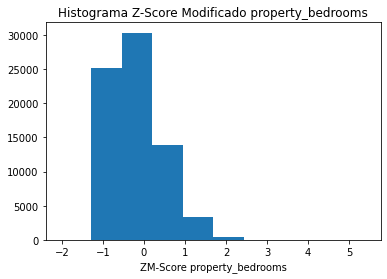

In [98]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_bedrooms)
plt.title('Histograma Z-Score Modificado property_bedrooms')
plt.xlabel('ZM-Score property_bedrooms')
plt.show()

In [ ]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_bedrooms']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

3. Variable 'property_price'

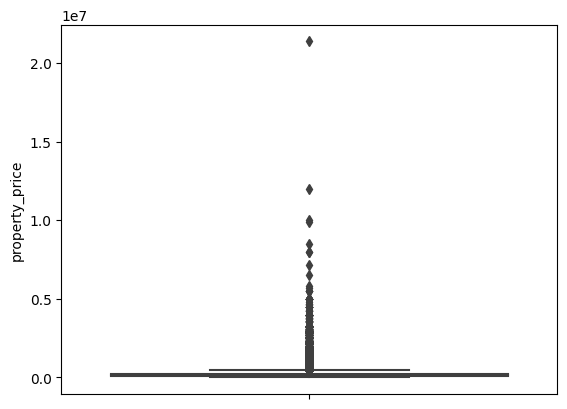

In [ ]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_price)
plt.show()

In [ ]:
#Cuartiles
Q1_property_price=np.quantile(ds_cropped_without_nans_and_anomalies.property_price,0.25)
Q3_property_price=np.quantile(ds_cropped_without_nans_and_anomalies.property_price,0.75)

#Rango intercuartil
IQR_property_price=Q3_property_price-Q1_property_price

#Limite inferior Outliers
out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print(out_inf)
print(out_sup)

-115000.0
445000.0


No consideramos que un cierto precio de una propiedad pueda ser outlier por sí sólo. Es mejor analizarlo en forma multivariada en base a la cantidad de habitaciones, superficie, etc. Una propiedad perfectamente podría valer 2e-7 si tiene muchísimas habitaciones y mucha superficie pero si tiene 1 habitación, por ejemplo, ya sería un caso más raro.

Ahora probemos lás técnicas z-score y z-score modificado:

In [99]:
#z-score property_price
media_property_price=np.mean(ds_cropped_without_nans_and_anomalies.property_price)
std_property_price=np.std(ds_cropped_without_nans_and_anomalies.property_price)
ds_cropped_without_nans_and_anomalies['z_property_price']=(ds_cropped_without_nans_and_anomalies.property_price - media_property_price)/std_property_price

#z-score modificado property_price
mediana_property_price=np.median(ds_cropped_without_nans_and_anomalies.property_price)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_price-mediana_property_price))

ds_cropped_without_nans_and_anomalies['zm_property_price']=(ds_cropped_without_nans_and_anomalies.property_price - mediana_property_price)*0.6745/MAD

In [101]:
ds_cropped_without_nans_and_anomalies.head()

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms,z_property_price,zm_property_price
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,65.000000,53.0,198000.0,1 - Holmberg 2700,-0.597690,-1.037612,-0.6745,-0.67450,-0.060194,0.711291
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.327588,0.009443,-1.3490,0.01108,-0.522542,-0.944300
211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-0.597690,-1.037612,-0.6745,-0.67450,-0.419798,-0.576391
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,Departamento,1.0,1.000000,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,-1.327588,-1.037612,-1.3490,-0.67450,-0.190337,0.245273
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,Departamento,1.0,2.000000,112.256728,78.0,290000.0,Departamento en Palermo,-1.327588,-0.007479,-1.3490,0.00000,0.254887,1.839545


Verificamos si se cumple la regla de oro:

In [102]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']>3]

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms,z_property_price,zm_property_price
134312,2021-04-06,2021-04-15,2021-04-06,-34.579205,-58.398950,Palermo,Casa,2.825976,4.000000,1000.000000,990.0,4500000.0,VENTA en Palermo Chico Barrio Parque Casa esti...,0.005187,2.052788,-0.117379,1.34900,14.673298,53.469455
367726,2021-04-10,2021-06-05,2021-04-10,-34.591166,-58.450646,Puerto Madero,Departamento,4.000000,3.000000,254.000000,188.0,1590000.0,252 m2 SLS Puerto Madero - Venta - 3 Suites,0.862104,1.022655,0.674500,0.67450,4.707128,17.782273
137477,2021-01-22,2021-06-05,2021-01-22,-34.566533,-58.448244,Belgrano,Departamento,4.000000,3.000000,223.000000,199.0,1390000.0,Belgrano - Torres Weik Belgrano - 4 Ambientes ...,0.862104,1.022655,0.674500,0.67450,4.022168,15.329545
197958,2021-04-17,2021-05-01,2021-04-17,-34.609558,-58.362674,Puerto Madero,Departamento,4.000000,2.000000,258.000000,258.0,1400000.0,OPORTUNIDAD TRIPLEX DE LUJO EN MOLINOS FAENA,0.862104,-0.007479,0.674500,0.00000,4.056416,15.452182
196891,2021-07-10,2021-11-24,2021-07-10,-34.577585,-58.400554,Palermo,Casa,2.825976,2.016427,112.256728,360.0,3500000.0,Venta casa Barrio Parque 3 dormitorios jardin ...,0.005187,0.009443,-0.117379,0.01108,11.248497,41.205818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103648,2021-05-28,2021-06-05,2021-05-28,-34.566206,-58.444766,Belgrano,Departamento,5.000000,3.000000,562.000000,320.0,2500000.0,RETASADO VENTA ÚNICO DUPLEX CON JARDÍN Y 2 PIL...,1.592002,1.022655,1.349000,0.67450,7.823697,28.942182
45398,2021-01-26,9999-12-31,2021-01-26,-34.617865,-58.360868,Puerto Madero,Departamento,4.000000,3.000000,112.256728,185.0,1150000.0,Departamento - Puerto Madero,0.862104,1.022655,0.674500,0.67450,3.200216,12.386273
287335,2021-06-16,2022-02-09,2021-06-16,-34.565859,-58.444674,Belgrano,Departamento,5.000000,4.000000,562.000000,300.0,2290000.0,Exclusivo Departamento 5 Ambientes en Belgrano,1.592002,2.052788,1.349000,1.34900,7.104488,26.366818
10991,2021-01-13,2021-01-13,2021-01-13,-34.564732,-58.441253,Belgrano,Departamento,5.000000,3.000000,279.000000,279.0,1200000.0,Espectacular Departamento de 5 Amb en torre de...,1.592002,1.022655,1.349000,0.67450,3.371456,12.999455


In [ ]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']<-3]

,property_price,z_property_price,zm_property_price


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


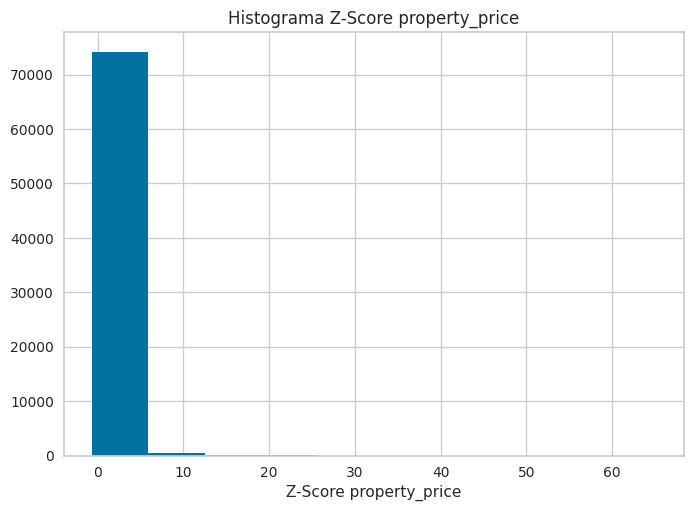

In [ ]:
plt.hist(ds_cropped_without_nans_and_anomalies.z_property_price)
plt.title('Histograma Z-Score property_price')
plt.xlabel('Z-Score property_price')
plt.show()

In [ ]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['z_property_price']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

In [ ]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']>3.5]

In [ ]:
ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']<-3.5]

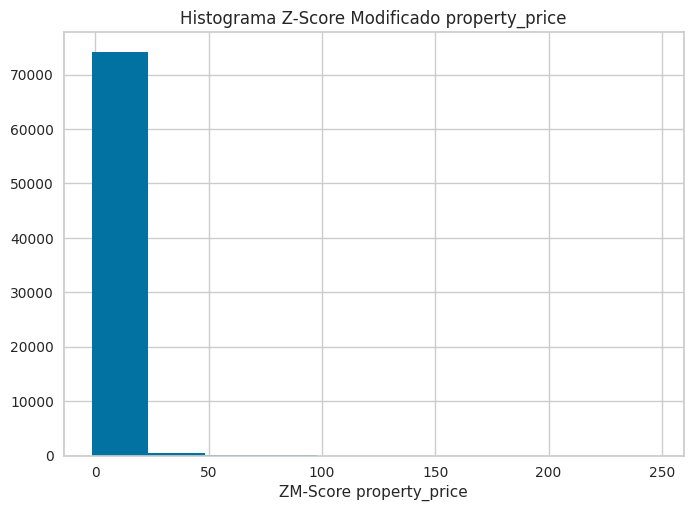

In [ ]:
plt.hist(ds_cropped_without_nans_and_anomalies.zm_property_price)
plt.title('Histograma Z-Score Modificado property_price')
plt.xlabel('ZM-Score property_price')
plt.show()

In [103]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']>3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_cropped_without_nans_and_anomalies[ds_cropped_without_nans_and_anomalies['zm_property_price']<-3.5].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

4. Variable 'property_surface_total'

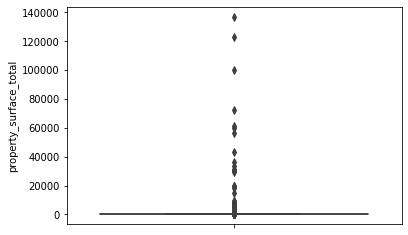

In [104]:
sns.boxplot(y=ds_cropped_without_nans_and_anomalies.property_surface_total)
plt.show()

In [ ]:
#Cuartiles
Q1_property_surface_total=np.quantile(ds_cropped_without_nans_and_anomalies.property_surface_total,0.25)
Q3_property_surface_total=np.quantile(ds_cropped_without_nans_and_anomalies.property_surface_total,0.75)

#Rango intercuartil
IQR_property_surface_total=Q3_property_surface_total-Q1_property_surface_total

#Limite inferior Outliers
out_inf=Q1_property_surface_total-1.5*IQR_property_surface_total
out_sup=Q3_property_surface_total+1.5*IQR_property_surface_total
print(out_inf)
print(out_sup)

In [ ]:
#z-score property_surface_total
media_property_surface_total=np.mean(ds_cropped_without_nans_and_anomalies.property_surface_total)
std_property_surface_total=np.std(ds_cropped_without_nans_and_anomalies.property_surface_total)
ds_cropped_without_nans_and_anomalies['z_property_surface_total']=(ds_property_price.property_surface_total - media_property_surface_total)/std_property_surface_total

#z-score modificado property_surface_total
mediana_property_surface_total=np.median(ds_cropped_without_nans_and_anomalies.property_surface_total)
MAD=np.median(np.absolute(ds_cropped_without_nans_and_anomalies.property_surface_total-mediana_property_surface_total))

ds_property_price['zm_property_surface_total']=(ds_cropped_without_nans_and_anomalies.property_surface_total - mediana_property_surface_total)*0.6745/MAD

In [ ]:
plt.hist(ds_property_surface_total.z_property_surface_total)
plt.title('Histograma Z-Score property_surface_total')
plt.xlabel('Z-Score property_surface_total')
plt.show()

In [ ]:
#Eliminación de outlier por índice de fila
indice_outlier=ds_property_price[ds_property_price['z_property_price']>3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)

indice_outlier=ds_property_price[ds_property_price['z_property_price']<-3].index
ds_cropped_without_nans_and_anomalies.drop(indice_outlier, inplace=True)


5. Variable 'propery_surface_covered'

### Análisis Multivariado

Vamos a analizar la presencia de outliers multivariados. 

### Distancia de Mahalanobis

1. Exploremos las variables 'property_rooms' y 'property_bedrooms'

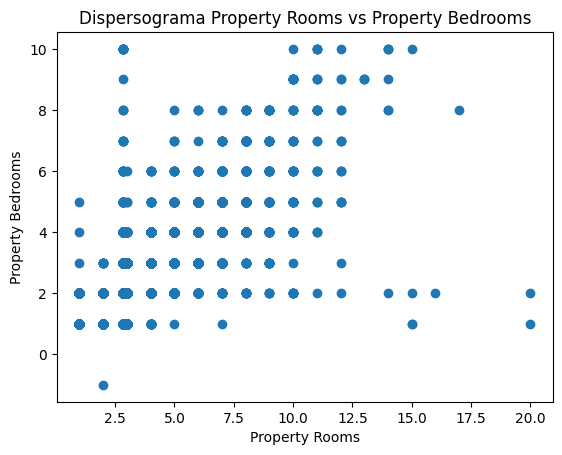

In [ ]:
#Scatter Plot
plt.scatter(ds_cropped_without_nans_and_anomalies.property_rooms,ds_cropped_without_nans_and_anomalies.property_bedrooms)
plt.title('Dispersograma Property Rooms vs Property Bedrooms')
plt.xlabel('Property Rooms')
plt.ylabel('Property Bedrooms')
plt.show()

Parecerían exisitir algunas observaciones anómalas, calculemos la distancia de mahalanobis para cada observación

In [ ]:
#Calculo el vector de medias
#vmedias=np.mean(ds_cropped_without_nans_and_anomalies[['property_rooms','property_bedrooms']])

#Calculo la diferencia entre las observaciones y el vector de medias
#x_dif = ds_cropped_without_nans_and_anomalies[['property_rooms','property_bedrooms']] - vmedias

#Calculo matriz de covarianza y su inversa
#cov=ds_cropped_without_nans_and_anomalies[['property_rooms','property_bedrooms']].cov().values
#inv_cov = np.linalg.inv(cov)

#Calculamos el cuadrado de la distancia de mahalanobis
#mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

#ds_cropped_without_nans_and_anomalies['mahalanobis']=mahal.diagonal()

In [ ]:
#ds_cropped_without_nans_and_anomalies.head()

Tenemos que seleccionar un valor umbral para definir qué observaciones podrían ser anómalas según la distancia de mahalanobis.

In [ ]:
#sns.boxplot(y=ds_cropped_without_nans_and_anomalies.mahalanobis)

In [ ]:
#Ordeno las distancias de menor a mayor
#np.sort(ds_cropped_without_nans_and_anomalies.mahalanobis)

### Local Outlier Factor (LOF)

1. Exploremos las variables 'property_rooms' y 'property_bedrooms'

In [107]:
from sklearn.neighbors import LocalOutlierFactor

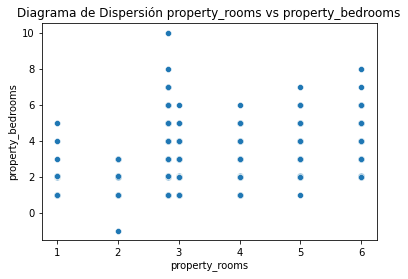

In [108]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_rooms",y="property_bedrooms")
plt.title('Diagrama de Dispersión property_rooms vs property_bedrooms')
plt.show()

In [109]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_rooms','property_bedrooms']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [ ]:
ds_scores.head()

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,scores
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,65.000000,53.0,198000.0,1 - Holmberg 2700,-1.0
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.0
211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-1.0
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,Departamento,1.0,1.000000,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,-1.0
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,Departamento,1.0,2.000000,112.256728,78.0,290000.0,Departamento en Palermo,-1.0


Visualicemos los datos y sus scores en un diagrama de dispersión

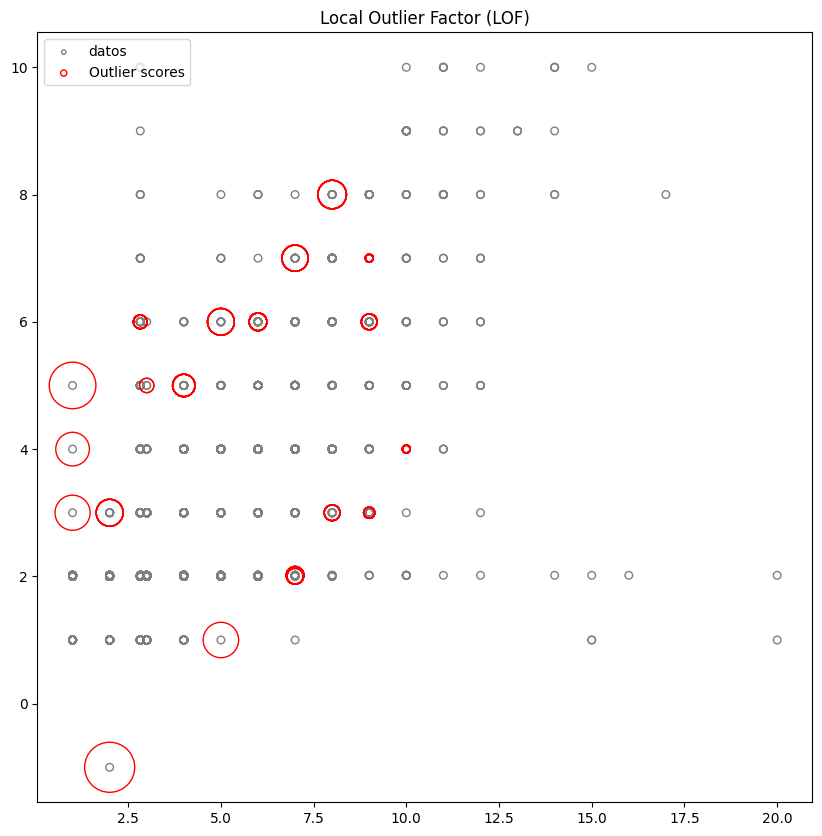

In [ ]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_bedrooms.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_bedrooms.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

TODO: Fijar un umbral y armar un scatter plot mostrando con diferentes colores los outliers de los datos normales

2. Exploremos las variables 'property_rooms' y 'property_surface_total'

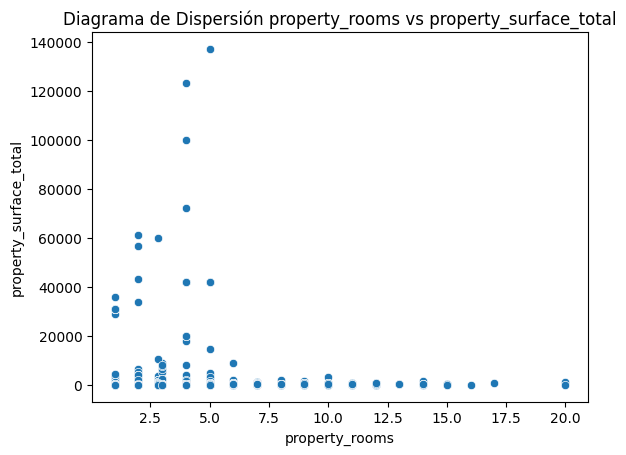

In [ ]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_rooms",y="property_surface_total")
plt.title('Diagrama de Dispersión property_rooms vs property_surface_total')
plt.show()

In [ ]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_rooms','property_surface_total']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [ ]:
ds_scores.head()

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,scores
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,65.000000,53.0,198000.0,1 - Holmberg 2700,-1.0
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.0
211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-1.0
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,Departamento,1.0,1.000000,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,-1.0
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,Departamento,1.0,2.000000,112.256728,78.0,290000.0,Departamento en Palermo,-1.0


Visualicemos los datos y sus scores en un diagrama de dispersión

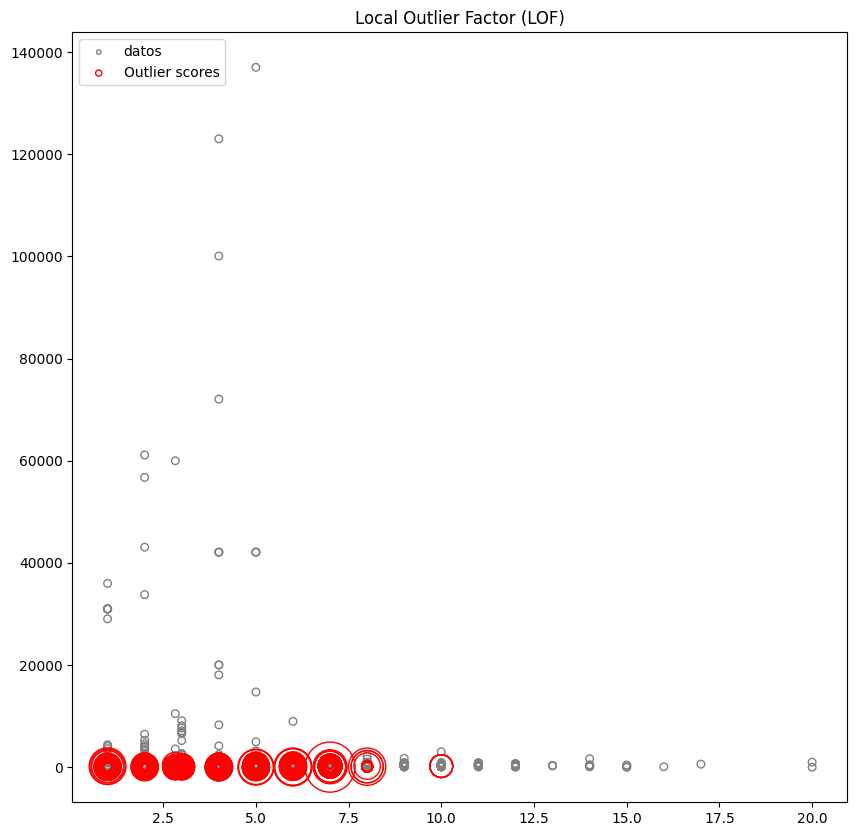

In [ ]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_surface_total.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_surface_total.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

TODO: Fijar un umbral y armar un scatter plot mostrando con diferentes colores los outliers de los datos normales

3. Exploremos las variables 'property_rooms' y 'property_price'

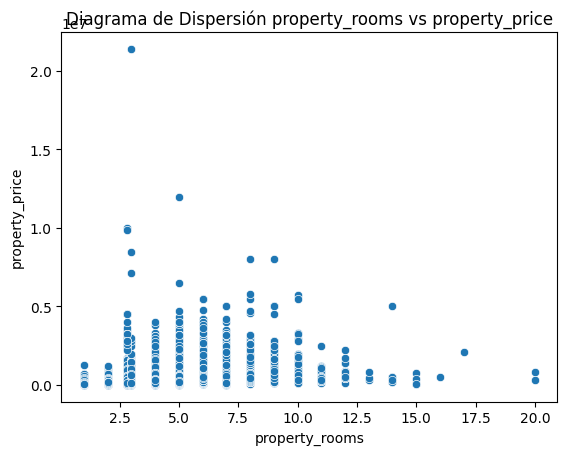

In [ ]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_rooms",y="property_price")
plt.title('Diagrama de Dispersión property_rooms vs property_price')
plt.show()

In [ ]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_rooms','property_price']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [ ]:
ds_scores.head()

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,scores
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,65.000000,53.0,198000.0,1 - Holmberg 2700,-1.000000e+00
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.000000e+00
211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-1.000000e+00
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,Departamento,1.0,1.000000,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,-1.000000e+00
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,Departamento,1.0,2.000000,112.256728,78.0,290000.0,Departamento en Palermo,-8.500000e+09


Visualicemos los datos y sus scores en un diagrama de dispersión

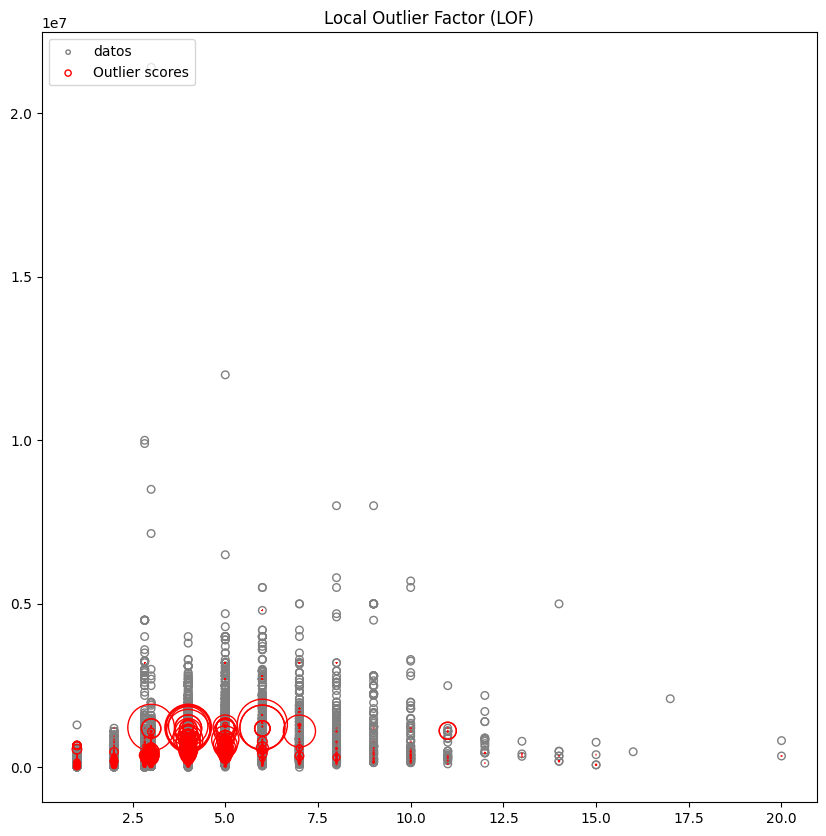

In [ ]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_price.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_rooms.values,ds_scores.property_price.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

Analizamos la relación entre el precio de venta y los metros de superficie:

4. Exploremos las variables 'property_price' y 'property_surface_total'

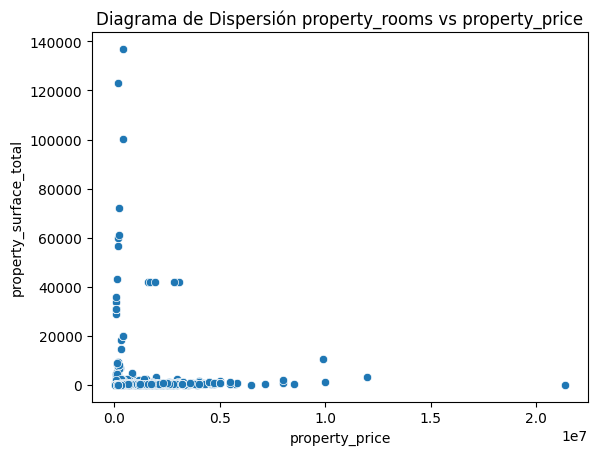

In [ ]:
sns.scatterplot(data=ds_cropped_without_nans_and_anomalies, x="property_price",y="property_surface_total")
plt.title('Diagrama de Dispersión property_rooms vs property_price')
plt.show()

In [ ]:
#Conjunto de entrenamiento
X=ds_cropped_without_nans_and_anomalies[['property_price','property_surface_total']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_scores = ds_cropped_without_nans_and_anomalies.copy()
ds_scores['scores']=clf.negative_outlier_factor_

In [ ]:
ds_scores.head()

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,scores
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,65.000000,53.0,198000.0,1 - Holmberg 2700,-1.012500
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,29.000000,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.081667
211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,41.000000,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-1.000000
228948,2021-03-08,2021-06-05,2021-03-08,-34.577033,-58.423367,Palermo,Departamento,1.0,1.000000,49.000000,44.0,160000.0,Departamento - Monoambiente - Palermo Nuevo - ...,-1.000000
361800,2021-01-16,2021-10-09,2021-01-16,-34.580210,-58.412815,Palermo,Departamento,1.0,2.000000,112.256728,78.0,290000.0,Departamento en Palermo,-1.000000


Visualicemos los datos y sus scores en un diagrama de dispersión

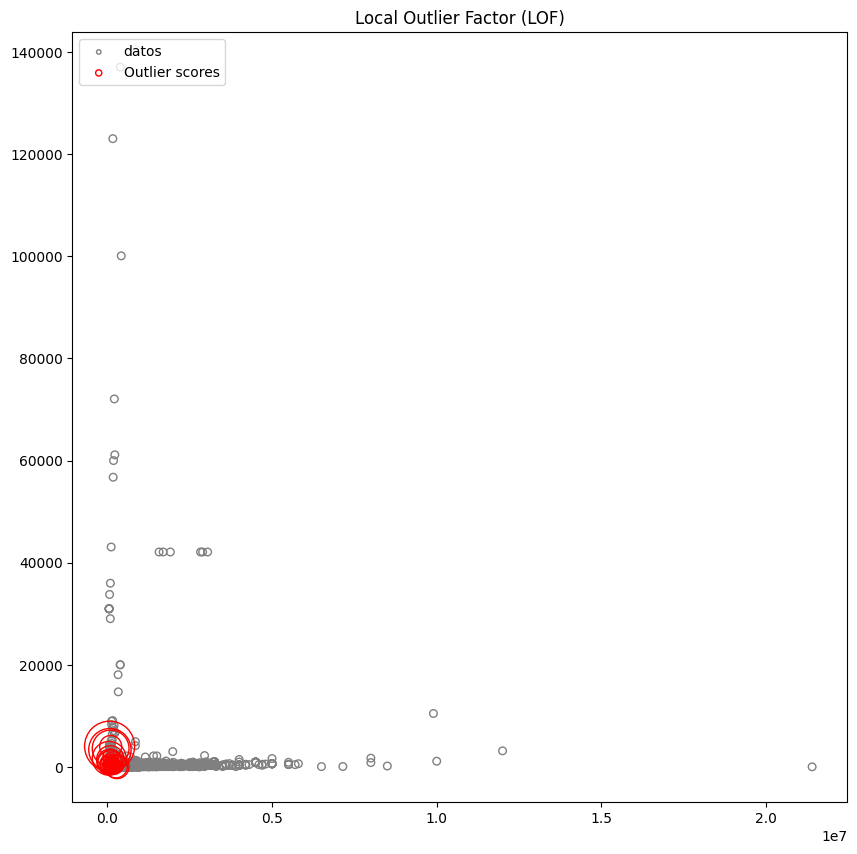

In [ ]:
#Calculo radio para plotear score
radius = (ds_scores.scores.max() - ds_scores.scores) / (ds_scores.scores.max() - ds_scores.scores.min())

#Grafico LOF
plt.figure(figsize=(10,10))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_scores.property_price.values,ds_scores.property_surface_total.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_scores.property_price.values,ds_scores.property_surface_total.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

## d) Reducción de la dimensionalidad

Vamos a crear un nuevo dataset que resulte de aplicar una reducción de dimensionalidad sobre el dataset que se obtuvo al finalizar el preprocesamiento.

### PCA - Análisis de Componentes Principales

Procedimiento matemático por el cual se transforma un conjunto de variables correlacionadas en un conjunto de variables no correlacionadas de menor dimensión. Estas nuevas variables se obtiene a partir de combinaciones lineales de las variables originales.
Estas nuevas variables son las que se denominan Componentes Principales

Esta técnica intenta hallar aquellas combinaciones lineales de las variables originales que maximizan la varianza (minimizan la pérdida de información original)

Esta técnica no requiere supuestos por lo que puede aplicarse siempre, sin embargo solo tiene sentido aplicarla si las variables originales estan relacionados entre si

El objetivo es reducir la dimensión del problema, es decir, descartar la información redundante

PCA ejecutado en 6 pasos:

1. Normalizar los atributos

undefined. Calcular la matriz de covarianza

undefined. Calcular autovalores y autovectores

undefined. Ordenar los autovalores por orden descendente para elegir las componentes a utilizar

undefined. Ordenar los autovectores en función del orden de los autovalores

undefined. Armar la matriz de transformación

Como PCA las columnas deben ser numéricas, deberíamos realizar alguna transformación de las variables categóricas. Pero, PCA no es bueno en matrices con tantos huecos como genera One Hot. Por lo tanto, trabajamos sólo con las variables numéricas y luego sumamos al nuevo dataset las categóricas transformadas.

In [110]:
dataset_pca = ds_cropped_without_nans_and_anomalies.copy()

columnas_a_borrar = ['start_date','end_date','created_on','property_type','neighborhood', 'property_title', 'latitud', 'longitud']

columnas_borradas = dataset_pca.filter(columnas_a_borrar, axis=1)
dataset_pca.drop(columns=columnas_a_borrar, inplace=True)

Ahora que todas las variables son numéricas, aplicamos PCA:

In [111]:
from sklearn.preprocessing import StandardScaler


x = dataset_pca.values
x = StandardScaler().fit_transform(x)

In [112]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3', 'cp_4', 'cp_5'])

In [113]:
pca.explained_variance_ratio_

array([0.61953614, 0.13583341, 0.13098483, 0.06350306, 0.05014255])

In [114]:
pca.get_covariance()

array([[1.00001493, 0.75066322, 0.03706603, 0.02798708, 0.62646286,
        1.00001493, 0.75066322, 1.00001493, 0.75066322, 0.62646286,
        0.62646286],
       [0.75066322, 1.00001493, 0.03554875, 0.02372059, 0.52155388,
        0.75066322, 1.00001493, 0.75066322, 1.00001493, 0.52155388,
        0.52155388],
       [0.03706603, 0.03554875, 1.00001493, 0.44829891, 0.04011897,
        0.03706603, 0.03554875, 0.03706603, 0.03554875, 0.04011897,
        0.04011897],
       [0.02798708, 0.02372059, 0.44829891, 1.00001493, 0.02961785,
        0.02798708, 0.02372059, 0.02798708, 0.02372059, 0.02961785,
        0.02961785],
       [0.62646286, 0.52155388, 0.04011897, 0.02961785, 1.00001493,
        0.62646286, 0.52155388, 0.62646286, 0.52155388, 1.00001493,
        1.00001493],
       [1.00001493, 0.75066322, 0.03706603, 0.02798708, 0.62646286,
        1.00001493, 0.75066322, 1.00001493, 0.75066322, 0.62646286,
        0.62646286],
       [0.75066322, 1.00001493, 0.03554875, 0.02372059, 0.

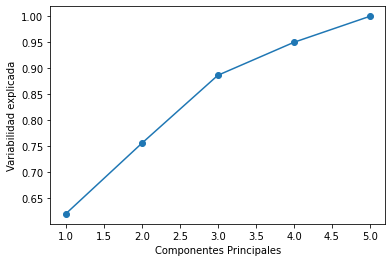

In [115]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

Nos quedaremos con 4 componentes principales ya que logramos una variablidad explicada de aproximadamente 95%

Seleccionamos 4 componentes principales y los juntamos con las columnas categoricas de nuestro dataset

In [122]:
new_pca_df = pca_df_aux.iloc[:,:4]
ds_with_categoric = ds_cropped_without_nans_and_anomalies[['start_date','end_date','created_on','property_type','neighborhood', 'property_title', 'latitud', 'longitud']]
reduced_df = pd.concat([new_pca_df.reset_index(drop=True), ds_with_categoric.reset_index(drop=True)], axis=1, join="inner")

reduced_df

,cp_1,cp_2,cp_3,cp_4,start_date,end_date,created_on,property_type,neighborhood,property_title,latitud,longitud
0,-1.142584,1.821184,-0.521961,-0.204897,2021-11-03,2022-02-02,2021-11-03,Departamento,Coghlan,1 - Holmberg 2700,-34.566536,-58.479638
1,-2.337040,-1.195604,0.327851,1.695430,2021-12-03,2022-01-27,2021-12-03,Departamento,Flores,Departamento a estrenar - Edificio con ameniti...,-34.645625,-58.459408
2,-2.310652,0.125679,-0.039205,-0.672550,2021-11-16,2021-11-18,2021-11-16,Departamento,Caballito,Departamento de 2 ambientes con balcón aterraz...,-34.591166,-58.450646
3,-2.515033,1.512915,-0.413586,0.821581,2021-03-08,2021-06-05,2021-03-08,Departamento,Palermo,Departamento - Monoambiente - Palermo Nuevo - ...,-34.577033,-58.423367
4,0.168655,2.495924,-0.694014,2.685616,2021-01-16,2021-10-09,2021-01-16,Departamento,Palermo,Departamento en Palermo,-34.580210,-58.412815
...,...,...,...,...,...,...,...,...,...,...,...,...
66955,-1.721004,0.982269,-0.280181,-0.436617,2021-09-08,2021-09-29,2021-09-08,Departamento,Belgrano,DEPARTAMENTO · 2 AMBIENTES · 11 DE SEPTIEMBRE ...,-34.552470,-58.456270
66956,-1.565219,1.208643,-0.343475,-0.374182,2021-05-12,2021-06-05,2021-05-12,Departamento,Coghlan,Departamento - Coghlan,-34.559379,-58.480078
66957,-1.843359,0.804611,-0.229733,-0.485508,2021-09-04,2021-09-26,2021-09-04,Departamento,Belgrano,VENTA DEPARTAMENTO BELGRANO R 2 AMBIENTES AMEN...,-34.568071,-58.458146
66958,0.389096,-0.545019,0.161228,-0.378155,2021-11-18,2022-01-27,2021-11-18,PH,Almagro,PH - Almagro,-34.604955,-58.422891


Nos guardamos el dataset reducido

In [125]:
reduced_df.to_csv("datasets/reducido.csv")
ds_cropped_without_nans_and_anomalies.to_csv("datasets/ds.csv")

# 2. Agrupamiento

Antes que nada, como para aplicar algunos métodos las columnas deben ser numéricas, convertimos las variables 'property_type' y 'neighborhood' que son del tipo categóricas a numéricas para poder aplicar las técnicas al modelo.

Variables Dummies -- One Hot Encoding

Algunos métodos analíticos requieren que las variables predictoras sean numéricas. Cuando tenemos categóricas, podemos recodificar la variable en una o más variables Dummies.

La forma de hacer esto es llevando cada categoría a una variable y completando con 0 o 1, es decir, llevar las categorías a variables que tomen valores binarios. De K categorías las podemos llevar a K-1 variables Dummies: si las K-1 están en 0 sabemos que es la otra que no está. Nunca va a pasar que haya más de un 1 porque son categorías excluyentes.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder() 
ds_cropped_without_nans_and_anomalies_ohe=ds_cropped_without_nans_and_anomalies.copy()

property_type_encoded = ohe.fit_transform(ds_cropped_without_nans_and_anomalies_ohe[['property_type']].astype(str)).todense().astype(int)

property_type_encoded = pd.DataFrame(property_type_encoded).add_prefix('property_type_')
display(property_type_encoded)

,property_type_0,property_type_1,property_type_2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
74526,0,1,0
74527,0,1,0
74528,0,1,0
74529,0,0,1


Para evitar problemas de colinealidad en los features se debe excluir una categoría del set (la ausencia de todas - vector de 0s - indica la presencia de la categoría faltante). La función de pandas ya viene con una parámetro para esto drop_first=True:

In [ ]:
df_dummies = pd.get_dummies(ds_cropped_without_nans_and_anomalies_ohe, columns=['property_type'], drop_first=True)
display(df_dummies.head(2))
print(df_dummies.shape)

,start_date,end_date,created_on,latitud,longitud,neighborhood,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,property_type_Departamento,property_type_PH
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,2.0,1.000000,65.0,53.0,198000.0,1 - Holmberg 2700,1,0
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,1.0,2.016427,29.0,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,1,0


(74531, 14)


Tambien, hacemos lo mismo para la variable 'neighborhood':

In [ ]:
neighborhood_encoded = ohe.fit_transform(df_dummies[['neighborhood']].astype(str)).todense().astype(int)

neighborhood_encoded = pd.DataFrame(neighborhood_encoded).add_prefix('neighborhood_')
display(neighborhood_encoded)

,neighborhood_0,neighborhood_1,neighborhood_2,neighborhood_3,neighborhood_4,neighborhood_5,neighborhood_6,neighborhood_7,neighborhood_8,neighborhood_9,...,neighborhood_48,neighborhood_49,neighborhood_50,neighborhood_51,neighborhood_52,neighborhood_53,neighborhood_54,neighborhood_55,neighborhood_56,neighborhood_57
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74526,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74528,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74529,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_dummies = pd.get_dummies(df_dummies, columns=['neighborhood'], drop_first=True)
display(df_dummies.head(2))
print(df_dummies.shape)

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,2.0,1.000000,65.0,53.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,1.0,2.016427,29.0,29.0,63000.0,...,0,0,0,0,0,0,0,0,0,0


(74531, 69)


También, para los atributos 'start_date', 'end_date' y 'created_on' los convertiremos usando el método pandas.to_datetime() para cambiar el tiempo de String a Date

In [ ]:
df_converted_date = df_dummies.copy()
df_converted_date["start_date"] = pd.to_datetime(df_converted_date["start_date"], errors = 'coerce')
df_converted_date["end_date"] = pd.to_datetime(df_converted_date["end_date"], errors = 'coerce')
df_converted_date["created_on"] = pd.to_datetime(df_converted_date["created_on"], errors = 'coerce')

df_converted_date.dtypes

start_date                       datetime64[ns]
end_date                         datetime64[ns]
created_on                       datetime64[ns]
latitud                                 float64
longitud                                float64
                                      ...      
neighborhood_Villa Riachuelo              uint8
neighborhood_Villa Santa Rita             uint8
neighborhood_Villa Soldati                uint8
neighborhood_Villa Urquiza                uint8
neighborhood_Villa del Parque             uint8
Length: 69, dtype: object

In [ ]:
df_converted_date.head(2)

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,2.0,1.000000,65.0,53.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,1.0,2.016427,29.0,29.0,63000.0,...,0,0,0,0,0,0,0,0,0,0


Ahora, las convierto a segundos para que queden variables numéricas:

In [ ]:
min(df_converted_date['start_date'])

Timestamp('2021-01-01 00:00:00')

In [ ]:
min(df_converted_date['end_date'])

Timestamp('2021-01-02 00:00:00')

In [ ]:
min(df_converted_date['created_on'])

Timestamp('2021-01-01 00:00:00')

In [ ]:
base_dt = pd.to_datetime('2021/01/01 00:00:00')

df_converted_date['start_date'] = (df_converted_date['start_date'] - base_dt).dt.total_seconds()
df_converted_date['end_date'] = (df_converted_date['end_date']- base_dt).dt.total_seconds()
df_converted_date['created_on'] = (df_converted_date['created_on']- base_dt).dt.total_seconds()

df_converted_date.dtypes

start_date                       float64
end_date                         float64
created_on                       float64
latitud                          float64
longitud                         float64
                                  ...   
neighborhood_Villa Riachuelo       uint8
neighborhood_Villa Santa Rita      uint8
neighborhood_Villa Soldati         uint8
neighborhood_Villa Urquiza         uint8
neighborhood_Villa del Parque      uint8
Length: 69, dtype: object

In [ ]:
df_converted_date.head(2)

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
256070,26438400.0,34300800.0,26438400.0,-34.566536,-58.479638,2.0,1.000000,65.0,53.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
27438,29030400.0,33782400.0,29030400.0,-34.645625,-58.459408,1.0,2.016427,29.0,29.0,63000.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_converted_date.dropna(inplace=True)

Por último, borramos la columna 'property_title' ya que consideramos que no aporta mucho:

In [ ]:
df_numeric = df_converted_date.copy()

df_numeric = df_numeric.drop(columns=['property_title'])

Ahora si queda un Dataset con todas las variables numéricas y podremos aplicar los distintos métodos

In [ ]:
from sklearn.cluster import KMeans

En este tipo de problemas se trata de agrupar los datos. Agruparlos de tal forma que queden definidos N conjuntos distinguibles, aunque no necesariamente se sepa que signifiquen esos conjuntos. El agrupamiento siempre será por características similares.

En este punto se busca analizar si es posible agrupar los datos en función de algún criterio. Para
esta tarea se utilizará el algoritmo K-Means y se van a realizar los siguientes pasos:

### a- Analizar la tendencia al clustering del dataset

### Hopkins: Tendencia al Clustering

La estadística de Hopkings se utiliza para evaluar la tendencia de agrupación de un conjunto de datos midiendo la probabilidad de que un conjunto de datos dado sea generado por una distribución de datos uniforme. En otras palabras, prueba la aleatoriedad espacial de los datos. La idea de esto es que nos da una idea si vamos a encontrar clusters o no en el Dataset.

In [ ]:
from pyclustertend import hopkins

hopkins(df_numeric, df_numeric.shape[0])

0.004728591465011837

Como dio un número bajo, esto significa que el Dataset tiene tendencia al Clustering.

### b - Estimar la cantidad apropiada de grupos que se deben formar

### Métricas de evaluación para Clustering

### ¿Cómo elegir el tamaño del Cluster?

Las métricas mas extendidas en clustering son el método de Elbow y el Índice de Silueta.

El método de Elbow consiste básicamente en verificar la evolución de la suma de los cuadrados del error para varias cantidades de clusters y verificar cual es el que brinda un mejor agrupamiento

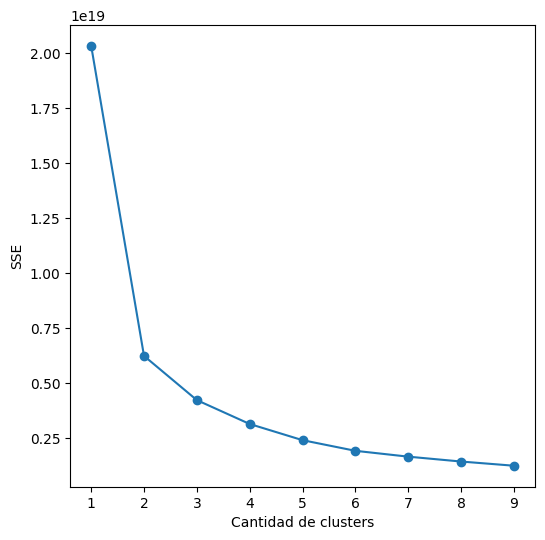

In [ ]:
# Corro el algoritmo con K entre 2 y 10 y voy guardando el error para luego graficarlo.
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_numeric)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

Observamos que el mayor quiebre de la pendiente se produce a los 2 clusters y lentamente se quiebra cada vez menos a medida que aumente la cantidad de clusters. Viendo el grafico utilizaremos 5 clusters ya que a partir de esta cantidad el quiebre es negligente.

### c - Evaluar la calidad de los grupos formados realizando un análisis de Silhouette

### Análisis de Silhouette

El Índice de Silueta indica si existen o no estructuras en los datos.

A continuación graficamos el índice de silueta variando la cantidad de clusters de 2 a 5 

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 6))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_numeric)

    score = silhouette_score (df_numeric, preds)
    print ("For n_clusters = " + str(n_clusters) + " silhouette score is " + str(score))

For n_clusters = 2 silhouette score is 0.5882597708861601
For n_clusters = 3 silhouette score is 0.4910561552793787
For n_clusters = 4 silhouette score is 0.5115533905766104
For n_clusters = 5 silhouette score is 0.45664785283096115


Evaluamos la calidad de los grupos formados utilizando el metodo de Silhoutte

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


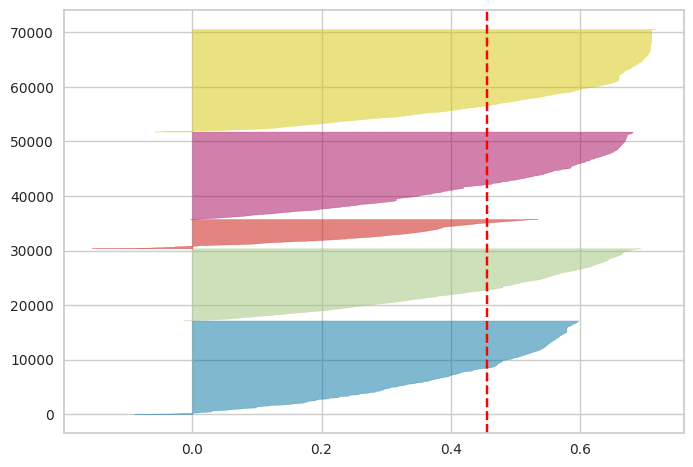

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(5, random_state=0)

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_numeric)
plt.show()

### Algoritmo de K-Means

1. El usuario decide la cantidad de grupos

undefined. K-Means elige al azar K centroides

undefined. Decide qué grupos están más cerca de cada centroide. Esos puntos forman un grupo

undefined. K-Means recalcula los centroides al centro de cada grupo.

undefined. K-Means vuelve a reasignar los puntos usando los nuevos centroides. Calcula nuevos grupos

undefined. K-Means repite punto 4. y 5. hasta que los puntos no combian de grupo.

In [ ]:
model.fit(df_numeric)
clusters = model.predict(df_numeric)

### d - Realizar un análisis de cada grupo intentando entender en función de qué
 características fueron formados

Para entender la relación que hay en cada grupo, lo visualizamos en un gráfico:

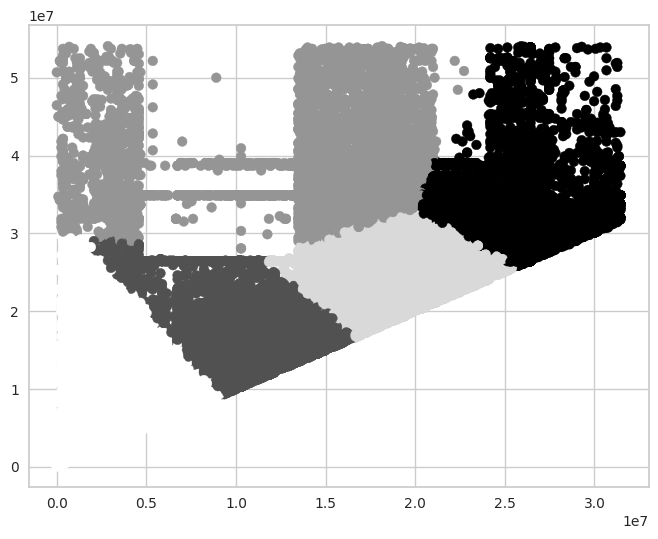

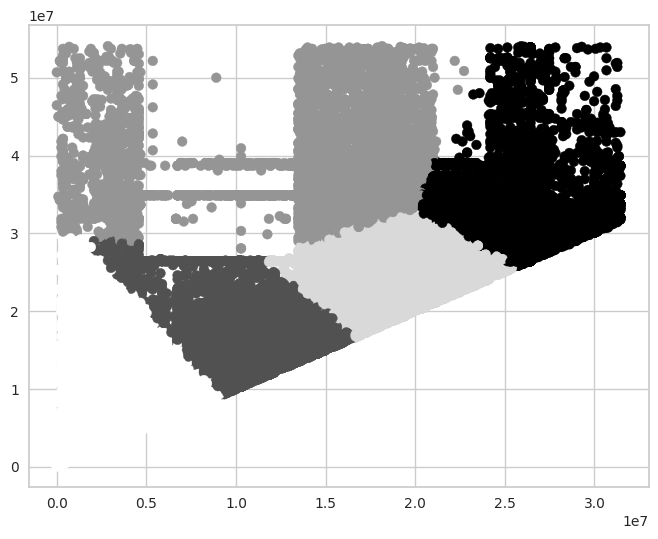

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_numeric.iloc[:,0].values,df_numeric.iloc[:,1].values, c=model.labels_.astype(float))

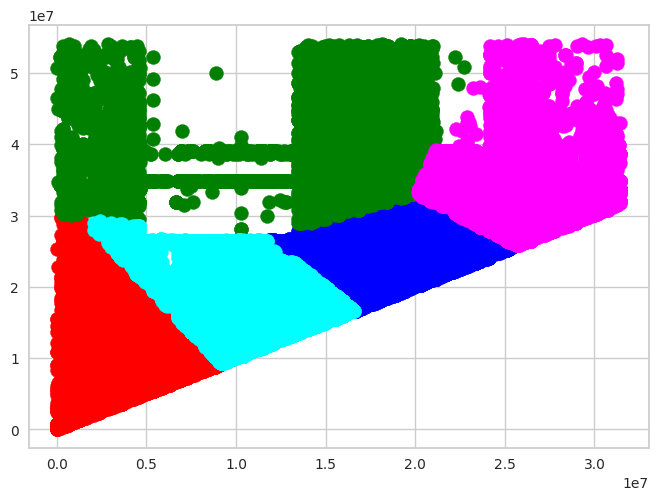

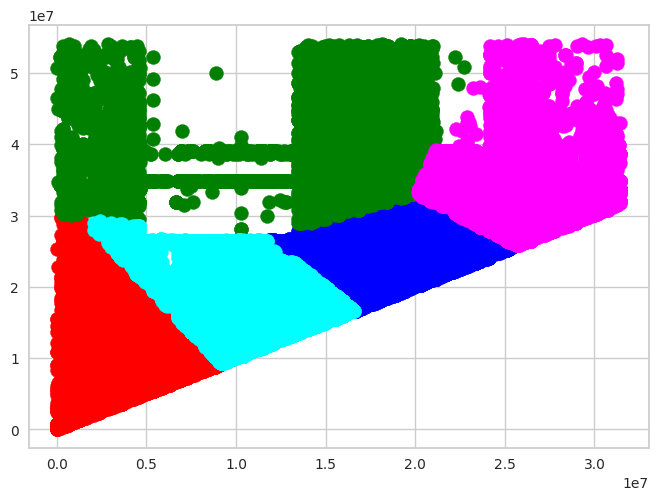

In [ ]:
plt.scatter(df_numeric.iloc[clusters==0, 0], df_numeric.iloc[clusters==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(df_numeric.iloc[clusters==1, 0], df_numeric.iloc[clusters==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(df_numeric.iloc[clusters==2, 0], df_numeric.iloc[clusters==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(df_numeric.iloc[clusters==3, 0], df_numeric.iloc[clusters==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(df_numeric.iloc[clusters==4, 0], df_numeric.iloc[clusters==4, 1], s=100, c='magenta', label ='Cluster 5')

Analizamos cada cluster por separado para entender en función de qué
 características fueron formados:

1. Primer Cluster

In [ ]:
df_numeric.iloc[clusters==0, :]

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
228948,5702400.0,13392000.0,5702400.0,-34.577033,-58.423367,1.000000,1.000000,49.000000,44.0,160000.0,...,0,0,0,0,0,0,0,0,0,0
361800,1296000.0,24278400.0,1296000.0,-34.580210,-58.412815,1.000000,2.000000,112.256728,78.0,290000.0,...,0,0,0,0,0,0,0,0,0,0
212313,6912000.0,10454400.0,6912000.0,-34.604367,-58.404872,3.000000,2.000000,60.000000,50.0,105000.0,...,0,0,0,0,0,0,0,0,0,0
178187,6998400.0,7257600.0,6998400.0,-34.609449,-58.393884,2.000000,1.000000,29.000000,29.0,55000.0,...,0,0,0,0,0,0,0,0,0,0
377901,6393600.0,9590400.0,6393600.0,-34.588119,-58.388227,3.000000,2.000000,87.000000,87.0,430000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60092,2073600.0,25574400.0,2073600.0,-34.625013,-58.443328,3.000000,2.000000,70.000000,66.0,235000.0,...,0,0,0,0,0,0,0,0,0,0
355717,7689600.0,8985600.0,7689600.0,-34.619137,-58.453847,1.000000,1.000000,33.000000,30.0,69000.0,...,0,0,0,0,0,0,0,0,0,0
212476,6912000.0,8121600.0,6912000.0,-34.587105,-58.431588,1.000000,2.016427,29.000000,26.0,82000.0,...,0,0,0,0,0,0,0,0,0,0
264371,4838400.0,5443200.0,4838400.0,-34.615136,-58.394638,1.000000,2.016427,22.000000,22.0,42000.0,...,0,0,0,0,0,0,0,0,0,0


,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
228948,5702400.0,13392000.0,5702400.0,-34.577033,-58.423367,1.000000,1.000000,49.000000,44.0,160000.0,...,0,0,0,0,0,0,0,0,0,0
361800,1296000.0,24278400.0,1296000.0,-34.580210,-58.412815,1.000000,2.000000,112.256728,78.0,290000.0,...,0,0,0,0,0,0,0,0,0,0
212313,6912000.0,10454400.0,6912000.0,-34.604367,-58.404872,3.000000,2.000000,60.000000,50.0,105000.0,...,0,0,0,0,0,0,0,0,0,0
178187,6998400.0,7257600.0,6998400.0,-34.609449,-58.393884,2.000000,1.000000,29.000000,29.0,55000.0,...,0,0,0,0,0,0,0,0,0,0
377901,6393600.0,9590400.0,6393600.0,-34.588119,-58.388227,3.000000,2.000000,87.000000,87.0,430000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60092,2073600.0,25574400.0,2073600.0,-34.625013,-58.443328,3.000000,2.000000,70.000000,66.0,235000.0,...,0,0,0,0,0,0,0,0,0,0
355717,7689600.0,8985600.0,7689600.0,-34.619137,-58.453847,1.000000,1.000000,33.000000,30.0,69000.0,...,0,0,0,0,0,0,0,0,0,0
212476,6912000.0,8121600.0,6912000.0,-34.587105,-58.431588,1.000000,2.016427,29.000000,26.0,82000.0,...,0,0,0,0,0,0,0,0,0,0
264371,4838400.0,5443200.0,4838400.0,-34.615136,-58.394638,1.000000,2.016427,22.000000,22.0,42000.0,...,0,0,0,0,0,0,0,0,0,0


2. Segundo Cluster

In [ ]:
df_numeric.iloc[clusters==1, :]

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
187633,13392000.0,23500800.0,13392000.0,-34.610446,-58.408441,1.0,1.000000,33.0,31.0,44900.0,...,0,0,0,0,0,0,0,0,0,0
163967,13564800.0,24192000.0,13564800.0,-34.579829,-58.433008,1.0,2.016427,41.0,30.0,99500.0,...,0,0,0,0,0,0,0,0,0,0
266218,21081600.0,21081600.0,21081600.0,-34.581770,-58.422489,4.0,3.000000,128.0,123.0,316242.0,...,0,0,0,0,0,0,0,0,0,0
76572,17020800.0,17107200.0,17020800.0,-34.590854,-58.415855,2.0,1.000000,33.0,30.0,95000.0,...,0,0,0,0,0,0,0,0,0,0
282339,22291200.0,22550400.0,22291200.0,-34.565047,-58.434799,3.0,2.000000,85.0,79.0,249000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254931,19958400.0,21081600.0,19958400.0,-34.613078,-58.435614,5.0,4.000000,168.0,159.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
347521,23500800.0,28425600.0,23500800.0,-34.574255,-58.460924,2.0,1.000000,55.0,55.0,119000.0,...,0,0,0,0,0,0,0,0,0,0
160556,16761600.0,17280000.0,16761600.0,-34.640558,-58.486536,3.0,2.000000,75.0,69.0,99500.0,...,0,0,0,0,0,0,0,0,0,0
415279,21600000.0,23414400.0,21600000.0,-34.552470,-58.456270,2.0,1.000000,51.0,51.0,146000.0,...,0,0,0,0,0,0,0,0,0,0


,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
187633,13392000.0,23500800.0,13392000.0,-34.610446,-58.408441,1.0,1.000000,33.0,31.0,44900.0,...,0,0,0,0,0,0,0,0,0,0
163967,13564800.0,24192000.0,13564800.0,-34.579829,-58.433008,1.0,2.016427,41.0,30.0,99500.0,...,0,0,0,0,0,0,0,0,0,0
266218,21081600.0,21081600.0,21081600.0,-34.581770,-58.422489,4.0,3.000000,128.0,123.0,316242.0,...,0,0,0,0,0,0,0,0,0,0
76572,17020800.0,17107200.0,17020800.0,-34.590854,-58.415855,2.0,1.000000,33.0,30.0,95000.0,...,0,0,0,0,0,0,0,0,0,0
282339,22291200.0,22550400.0,22291200.0,-34.565047,-58.434799,3.0,2.000000,85.0,79.0,249000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254931,19958400.0,21081600.0,19958400.0,-34.613078,-58.435614,5.0,4.000000,168.0,159.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
347521,23500800.0,28425600.0,23500800.0,-34.574255,-58.460924,2.0,1.000000,55.0,55.0,119000.0,...,0,0,0,0,0,0,0,0,0,0
160556,16761600.0,17280000.0,16761600.0,-34.640558,-58.486536,3.0,2.000000,75.0,69.0,99500.0,...,0,0,0,0,0,0,0,0,0,0
415279,21600000.0,23414400.0,21600000.0,-34.552470,-58.456270,2.0,1.000000,51.0,51.0,146000.0,...,0,0,0,0,0,0,0,0,0,0


3. Tercer Cluster

In [ ]:
df_numeric.iloc[clusters==2, :]

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
251741,14515200.0,34905600.0,14515200.0,-34.616469,-58.370769,4.0,4.000000,257.0,178.0,249900.0,...,0,0,0,0,0,0,0,0,0,0
360651,1296000.0,33350400.0,1296000.0,-34.643060,-58.361352,6.0,4.000000,199.0,157.0,160000.0,...,0,0,0,0,0,0,0,0,0,0
26134,15033600.0,51062400.0,15033600.0,-34.593049,-58.379873,3.0,2.000000,120.0,120.0,390000.0,...,0,0,0,0,0,0,0,0,0,0
155007,2851200.0,43113600.0,2851200.0,-34.591166,-58.450646,1.0,2.016427,47.0,32.0,66780.0,...,0,0,0,0,0,0,0,0,0,0
439706,17280000.0,33436800.0,17280000.0,-34.601138,-58.459027,3.0,2.000000,41.0,41.0,75000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147746,19872000.0,33782400.0,19872000.0,-34.591166,-58.450646,2.0,1.000000,71.0,57.0,160000.0,...,0,0,0,0,0,0,0,0,0,0
114221,13737600.0,29376000.0,13737600.0,-34.610095,-58.503822,2.0,1.000000,43.0,28.0,107000.0,...,0,0,0,0,0,0,0,0,0,0
147647,19872000.0,33782400.0,19872000.0,-34.566348,-58.437582,4.0,3.000000,133.0,130.0,340000.0,...,0,0,0,0,0,0,0,0,0,0
271050,16675200.0,36806400.0,16675200.0,-34.632545,-58.475753,5.0,4.000000,194.0,106.0,245000.0,...,0,0,0,0,0,0,0,0,0,0


,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
251741,14515200.0,34905600.0,14515200.0,-34.616469,-58.370769,4.0,4.000000,257.0,178.0,249900.0,...,0,0,0,0,0,0,0,0,0,0
360651,1296000.0,33350400.0,1296000.0,-34.643060,-58.361352,6.0,4.000000,199.0,157.0,160000.0,...,0,0,0,0,0,0,0,0,0,0
26134,15033600.0,51062400.0,15033600.0,-34.593049,-58.379873,3.0,2.000000,120.0,120.0,390000.0,...,0,0,0,0,0,0,0,0,0,0
155007,2851200.0,43113600.0,2851200.0,-34.591166,-58.450646,1.0,2.016427,47.0,32.0,66780.0,...,0,0,0,0,0,0,0,0,0,0
439706,17280000.0,33436800.0,17280000.0,-34.601138,-58.459027,3.0,2.000000,41.0,41.0,75000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147746,19872000.0,33782400.0,19872000.0,-34.591166,-58.450646,2.0,1.000000,71.0,57.0,160000.0,...,0,0,0,0,0,0,0,0,0,0
114221,13737600.0,29376000.0,13737600.0,-34.610095,-58.503822,2.0,1.000000,43.0,28.0,107000.0,...,0,0,0,0,0,0,0,0,0,0
147647,19872000.0,33782400.0,19872000.0,-34.566348,-58.437582,4.0,3.000000,133.0,130.0,340000.0,...,0,0,0,0,0,0,0,0,0,0
271050,16675200.0,36806400.0,16675200.0,-34.632545,-58.475753,5.0,4.000000,194.0,106.0,245000.0,...,0,0,0,0,0,0,0,0,0,0


4. Cuarto Cluster

In [ ]:
df_numeric.iloc[clusters==3, :]

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
445441,12009600.0,13392000.0,12009600.0,-34.591166,-58.450646,3.0,2.0,72.000000,65.000000,198000.0,...,0,0,0,0,0,0,0,0,0,0
286235,14342400.0,19353600.0,14342400.0,-34.611728,-58.388853,3.0,2.0,65.000000,54.000000,62000.0,...,0,0,0,0,0,0,0,0,0,0
183767,9244800.0,13392000.0,9244800.0,-34.577227,-58.404563,3.0,2.0,112.256728,133.000000,380000.0,...,0,0,0,0,0,0,0,0,0,0
24269,10540800.0,13392000.0,10540800.0,-34.605064,-58.411524,2.0,1.0,35.000000,35.000000,67500.0,...,0,0,0,0,0,0,0,0,0,0
52130,11664000.0,11836800.0,11664000.0,-34.603217,-58.440263,2.0,1.0,43.000000,38.000000,72000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96174,15724800.0,15811200.0,15724800.0,-34.622861,-58.460870,4.0,3.0,117.000000,102.000000,230000.0,...,0,0,0,0,0,0,0,0,0,0
103852,12700800.0,23414400.0,12700800.0,-34.609396,-58.448392,2.0,1.0,42.000000,38.000000,109000.0,...,0,0,0,0,0,0,0,0,0,0
164293,13564800.0,18489600.0,13564800.0,-34.616987,-58.445827,4.0,3.0,96.000000,87.000000,290000.0,...,0,0,0,0,0,0,0,0,0,0
149099,11318400.0,13392000.0,11318400.0,-34.559379,-58.480078,2.0,1.0,58.000000,51.000000,160000.0,...,0,0,0,0,0,0,0,0,0,0


,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
445441,12009600.0,13392000.0,12009600.0,-34.591166,-58.450646,3.0,2.0,72.000000,65.000000,198000.0,...,0,0,0,0,0,0,0,0,0,0
286235,14342400.0,19353600.0,14342400.0,-34.611728,-58.388853,3.0,2.0,65.000000,54.000000,62000.0,...,0,0,0,0,0,0,0,0,0,0
183767,9244800.0,13392000.0,9244800.0,-34.577227,-58.404563,3.0,2.0,112.256728,133.000000,380000.0,...,0,0,0,0,0,0,0,0,0,0
24269,10540800.0,13392000.0,10540800.0,-34.605064,-58.411524,2.0,1.0,35.000000,35.000000,67500.0,...,0,0,0,0,0,0,0,0,0,0
52130,11664000.0,11836800.0,11664000.0,-34.603217,-58.440263,2.0,1.0,43.000000,38.000000,72000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96174,15724800.0,15811200.0,15724800.0,-34.622861,-58.460870,4.0,3.0,117.000000,102.000000,230000.0,...,0,0,0,0,0,0,0,0,0,0
103852,12700800.0,23414400.0,12700800.0,-34.609396,-58.448392,2.0,1.0,42.000000,38.000000,109000.0,...,0,0,0,0,0,0,0,0,0,0
164293,13564800.0,18489600.0,13564800.0,-34.616987,-58.445827,4.0,3.0,96.000000,87.000000,290000.0,...,0,0,0,0,0,0,0,0,0,0
149099,11318400.0,13392000.0,11318400.0,-34.559379,-58.480078,2.0,1.0,58.000000,51.000000,160000.0,...,0,0,0,0,0,0,0,0,0,0


5. Quinto Cluster

In [ ]:
df_numeric.iloc[clusters==4, :]

,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
256070,26438400.0,34300800.0,26438400.0,-34.566536,-58.479638,2.0,1.000000,65.0,53.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
27438,29030400.0,33782400.0,29030400.0,-34.645625,-58.459408,1.0,2.016427,29.0,29.0,63000.0,...,0,0,0,0,0,0,0,0,0,0
211207,27561600.0,27734400.0,27561600.0,-34.591166,-58.450646,2.0,1.000000,41.0,35.0,93000.0,...,0,0,0,0,0,0,0,0,0,0
153179,29548800.0,30153600.0,29548800.0,-34.582107,-58.448826,1.0,1.000000,36.0,31.0,83789.0,...,0,0,0,0,0,0,0,0,0,0
53530,22809600.0,37324800.0,22809600.0,-34.581356,-58.433269,2.0,1.000000,70.0,66.0,205000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255850,26438400.0,27216000.0,26438400.0,-34.544466,-58.471032,1.0,2.016427,60.0,29.0,121333.0,...,0,0,0,0,0,0,0,0,0,0
54005,22809600.0,34905600.0,22809600.0,-34.600961,-58.376123,2.0,1.000000,55.0,55.0,91000.0,...,0,0,0,0,0,0,0,0,0,0
172381,30499200.0,34905600.0,30499200.0,-34.573918,-58.439126,2.0,1.000000,44.0,35.0,77500.0,...,0,0,0,0,0,0,0,0,0,0
215681,27648000.0,33782400.0,27648000.0,-34.602083,-58.363912,3.0,2.000000,145.0,111.0,650000.0,...,0,0,0,0,0,0,0,0,0,0


,start_date,end_date,created_on,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
256070,26438400.0,34300800.0,26438400.0,-34.566536,-58.479638,2.0,1.000000,65.0,53.0,198000.0,...,0,0,0,0,0,0,0,0,0,0
27438,29030400.0,33782400.0,29030400.0,-34.645625,-58.459408,1.0,2.016427,29.0,29.0,63000.0,...,0,0,0,0,0,0,0,0,0,0
211207,27561600.0,27734400.0,27561600.0,-34.591166,-58.450646,2.0,1.000000,41.0,35.0,93000.0,...,0,0,0,0,0,0,0,0,0,0
153179,29548800.0,30153600.0,29548800.0,-34.582107,-58.448826,1.0,1.000000,36.0,31.0,83789.0,...,0,0,0,0,0,0,0,0,0,0
53530,22809600.0,37324800.0,22809600.0,-34.581356,-58.433269,2.0,1.000000,70.0,66.0,205000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255850,26438400.0,27216000.0,26438400.0,-34.544466,-58.471032,1.0,2.016427,60.0,29.0,121333.0,...,0,0,0,0,0,0,0,0,0,0
54005,22809600.0,34905600.0,22809600.0,-34.600961,-58.376123,2.0,1.000000,55.0,55.0,91000.0,...,0,0,0,0,0,0,0,0,0,0
172381,30499200.0,34905600.0,30499200.0,-34.573918,-58.439126,2.0,1.000000,44.0,35.0,77500.0,...,0,0,0,0,0,0,0,0,0,0
215681,27648000.0,33782400.0,27648000.0,-34.602083,-58.363912,3.0,2.000000,145.0,111.0,650000.0,...,0,0,0,0,0,0,0,0,0,0


### e - Graficar sobre un mapa de CABA los avisos coloreados segun el grupo al que pertenecen

In [ ]:
color_map = {
    0: 'magenta',
    1: 'cyan',
    2: 'green',
    3: 'blue',
    4: 'red'
}

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

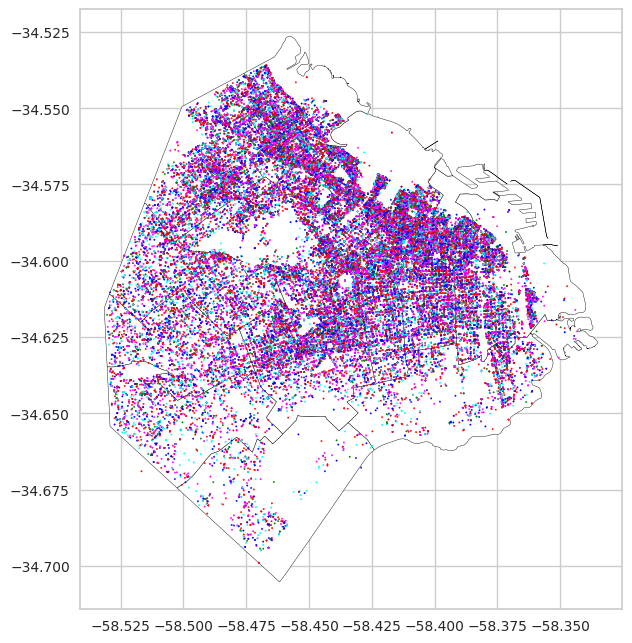

/shared-libs/python3.9/py/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


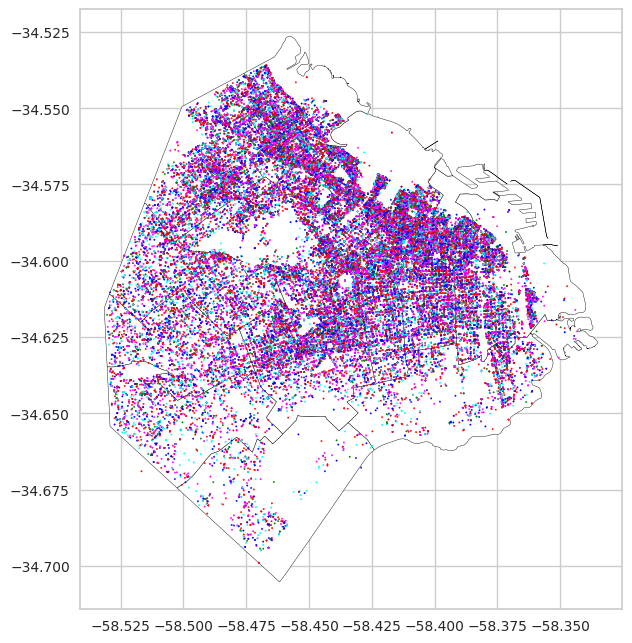

In [ ]:
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 10))

df = df_numeric[(df_numeric['latitud'] < -34) & (df_numeric['latitud'] > -35) & (df_numeric['longitud'] > -59)]

# Reemplazar este dataframe por el nuestro
# Aca solo tendriamos que cambiar lat y long para que usen los del dataframe
# Lo que hace aca es convertir latitude y longitude en puntos
gdf = gpd.GeoDataFrame(df.drop(['latitud', 'longitud'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=[shapely.geometry.Point(xy)
                                 for xy in zip(df.longitud, df.latitud)])
world = gpd.read_file('mapa_caba/mapa.shp')


base = world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', markersize=1, c=[color_map[label] for label in model.labels_])

plt.show()

### Análisis para 3 grupos

A continuación se realizará el mismo analisis pero para solamente para 3 grupos.

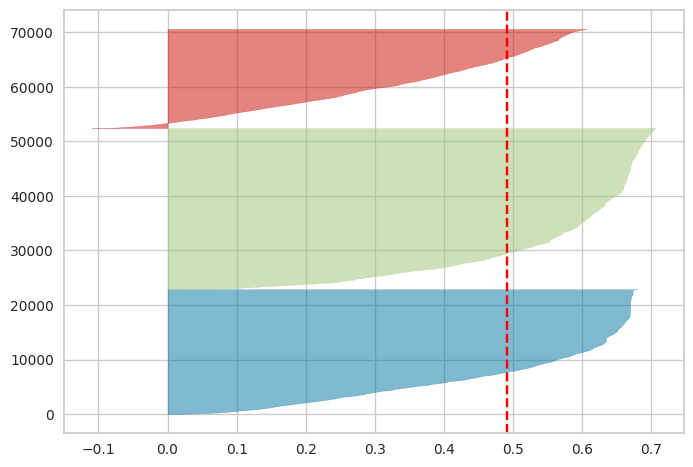

KeyboardInterrupt: 

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model_3 = KMeans(3, random_state=0)

# Volvemos a visualizar el gráfico de silueta
visualizer_3 = SilhouetteVisualizer(model_3, colors='yellowbrick')
visualizer_3.fit(df_numeric)
plt.show()

In [ ]:
df_test_numeric = df_numeric.copy()
df_test_numeric = df_test_numeric.drop(columns=['start_date', 'end_date', 'created_on'])

In [ ]:
model_3.fit(df_test_numeric)
clusters_3 = model_3.predict(df_test_numeric)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

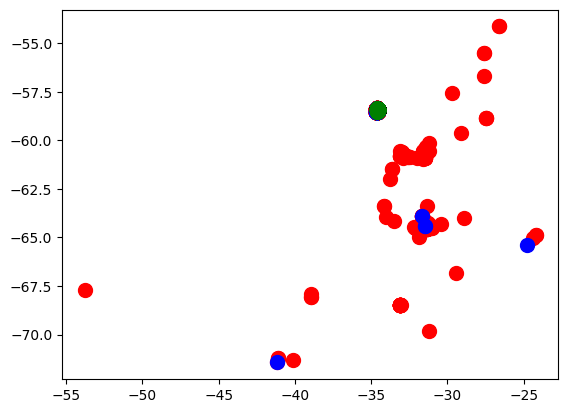

In [ ]:
plt.scatter(df_test_numeric.iloc[clusters_3==0, 0], df_test_numeric.iloc[clusters_3==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(df_test_numeric.iloc[clusters_3==1, 0], df_test_numeric.iloc[clusters_3==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(df_test_numeric.iloc[clusters_3==2, 0], df_test_numeric.iloc[clusters_3==2, 1], s=100, c='green', label ='Cluster 3')

Volvemos a analizamos cada cluster por separado:

1. Primer Cluster

In [ ]:
df_test_numeric.iloc[clusters_3==0, :]

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Departamento,property_type_PH,neighborhood_Agronomía,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
256070,-34.566536,-58.479638,2.0,1.000000,65.000000,53.000000,198000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
27438,-34.645625,-58.459408,1.0,2.016427,29.000000,29.000000,63000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
211207,-34.591166,-58.450646,2.0,1.000000,41.000000,35.000000,93000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
228948,-34.577033,-58.423367,1.0,1.000000,49.000000,44.000000,160000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
361800,-34.580210,-58.412815,1.0,2.000000,112.256728,78.000000,290000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415279,-34.552470,-58.456270,2.0,1.000000,51.000000,51.000000,146000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
149099,-34.559379,-58.480078,2.0,1.000000,58.000000,51.000000,160000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
217366,-34.568071,-58.458146,2.0,1.000000,52.000000,45.000000,135000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
356023,-34.604955,-58.422891,3.0,2.000000,123.000000,71.000000,139000.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


2. Segundo Cluster

In [ ]:
df_test_numeric.iloc[clusters_3==1, :]

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Departamento,property_type_PH,neighborhood_Agronomía,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
318910,-34.573333,-58.421634,3.0,2.0,110.0,100.0,550000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
307877,-34.591166,-58.450646,5.0,5.0,192.0,182.0,585000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
229171,-34.592048,-58.392022,4.0,3.0,182.0,182.0,495000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
274591,-34.582185,-58.401540,5.0,3.0,194.0,194.0,780000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
45841,-34.561566,-58.464539,5.0,3.0,177.0,111.0,490000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334298,-34.590131,-58.384749,5.0,2.0,325.0,309.0,1750000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
73549,-34.551935,-58.442412,4.0,3.0,138.0,127.0,695000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
141135,-34.631387,-58.429794,6.0,5.0,246.0,159.0,479900.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
94498,-34.564240,-58.450937,5.0,3.0,230.0,215.0,565000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


3. Tercer Cluster

In [ ]:
df_test_numeric.iloc[clusters_3==2, :]

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_type_Departamento,property_type_PH,neighborhood_Agronomía,...,neighborhood_Villa Lugano,neighborhood_Villa Luro,neighborhood_Villa Ortuzar,neighborhood_Villa Pueyrredón,neighborhood_Villa Real,neighborhood_Villa Riachuelo,neighborhood_Villa Santa Rita,neighborhood_Villa Soldati,neighborhood_Villa Urquiza,neighborhood_Villa del Parque
358714,-34.590923,-58.384214,9.000000,4.000000,668.000000,668.0,5000000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
134312,-34.579205,-58.398950,2.825976,4.000000,1000.000000,990.0,4500000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196891,-34.577585,-58.400554,2.825976,2.016427,112.256728,360.0,3500000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158371,-34.574864,-58.421311,7.000000,4.000000,400.000000,400.0,3500000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
306543,-34.590923,-58.384214,7.000000,3.000000,318.000000,318.0,1900000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365464,-34.567172,-58.430634,5.000000,4.000000,400.000000,400.0,4000000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
129764,-34.571179,-58.431863,7.000000,4.000000,425.000000,400.0,2100000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
103648,-34.566206,-58.444766,5.000000,3.000000,562.000000,320.0,2500000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
287335,-34.565859,-58.444674,5.000000,4.000000,562.000000,300.0,2290000.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Grafico de mapa de CABA con cada cluster

NameError: name 'df_test_numeric' is not defined

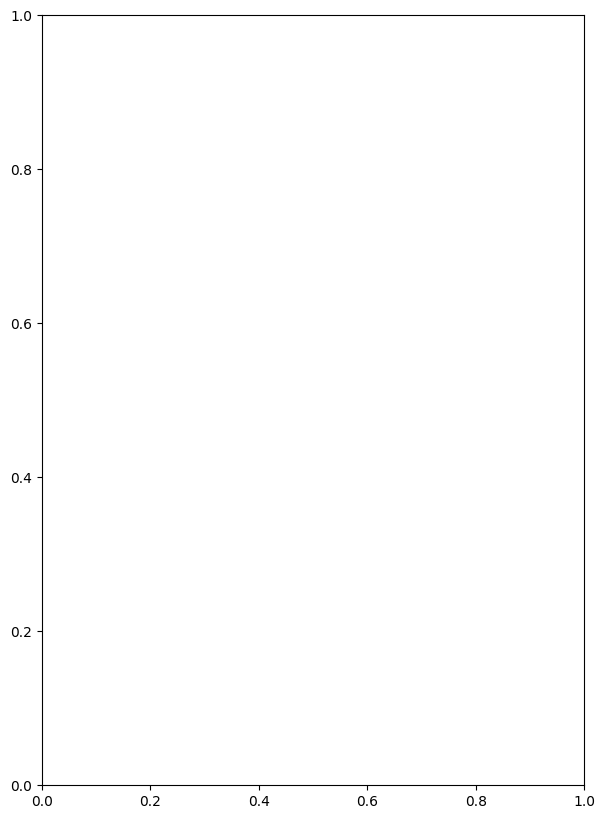

In [ ]:
import geopandas as gpd
import shapely

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 10))

df = df_test_numeric[(df_test_numeric['latitud'] < -34) & (df_test_numeric['latitud'] > -35) & (df_test_numeric['longitud'] > -59)]

# Reemplazar este dataframe por el nuestro
# Aca solo tendriamos que cambiar lat y long para que usen los del dataframe
# Lo que hace aca es convertir latitude y longitude en puntos
gdf = gpd.GeoDataFrame(df.drop(['latitud', 'longitud'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=[shapely.geometry.Point(xy)
                                 for xy in zip(df.longitud, df.latitud)])
world = gpd.read_file('mapa_caba/mapa.shp')


base = world.plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', markersize=1, c=[color_map[label] for label in model_3.labels_])

plt.show()

### Guardado del modelo entrenado

Se procede a guardar el modelo que se ha entrenado para que pueda ser usado sin tener que re-entrenarlo posteriormente.

In [ ]:
from joblib import dump, load
dump(model, 'fitted_model.joblib')

# Usar model = load('fitted_model.joblib') para cargar el mismo.

NameError: name 'df_numeris_fitted' is not defined

to do: investigar lo de pipeline para hacer mismas transformaciones de training y test

## Clasificacion

### Construccion del target

Cargamos nuestro dataset reducido y crearemos una nueva columna 'pxm2' que sera el precio por metro cuadrado, que sera la columna que nos dira si una priopiedad tiene un tipo de precio alto, medio o bajo

In [130]:
df_clasification = pd.read_csv("datasets/ds.csv")

df_clasification['pxm2'] = df_clasification['property_price'] / df_clasification['property_surface_total'] 
df_clasification.head(3)

,Unnamed: 0,start_date,end_date,created_on,latitud,longitud,neighborhood,property_type,property_rooms,property_bedrooms,...,property_surface_covered,property_price,property_title,z_property_rooms,z_property_bedrooms,zm_property_rooms,zm_property_bedrooms,z_property_price,zm_property_price,pxm2
0,256070,2021-11-03,2022-02-02,2021-11-03,-34.566536,-58.479638,Coghlan,Departamento,2.0,1.000000,...,53.0,198000.0,1 - Holmberg 2700,-0.597690,-1.037612,-0.6745,-0.67450,-0.060194,0.711291,3046.153846
1,27438,2021-12-03,2022-01-27,2021-12-03,-34.645625,-58.459408,Flores,Departamento,1.0,2.016427,...,29.0,63000.0,Departamento a estrenar - Edificio con ameniti...,-1.327588,0.009443,-1.3490,0.01108,-0.522542,-0.944300,2172.413793
2,211207,2021-11-16,2021-11-18,2021-11-16,-34.591166,-58.450646,Caballito,Departamento,2.0,1.000000,...,35.0,93000.0,Departamento de 2 ambientes con balcón aterraz...,-0.597690,-1.037612,-0.6745,-0.67450,-0.419798,-0.576391,2268.292683


Analizamos su distribucion

**Distribucion de precio por metro cuadrado**

[Text(0.5, 1.0, 'Grafico de distribucion de precio por metro cuadrado')]

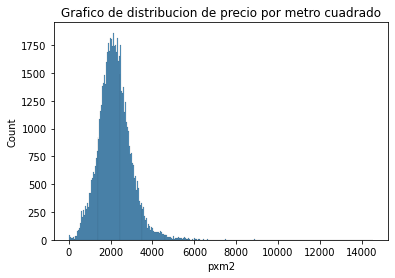

In [141]:
ax = sns.histplot(data=df_clasification, x=df_clasification['pxm2'])
ax.set(title="Grafico de distribucion de precio por metro cuadrado")

**Distribucion de precio por metro cuadrado por tipo de propiedad**

[Text(0.5, 1.0, 'Distribucion de precio por metro cuadrado por tipo de propiedad')]

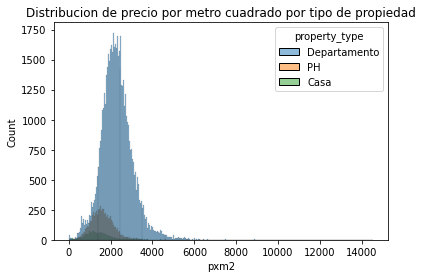

In [148]:
ax = sns.histplot(data=df_clasification, x=df_clasification['pxm2'], hue='property_type')
ax.set(title="Distribucion de precio por metro cuadrado por tipo de propiedad")

Para saber los limites de cada categoria tenemos las siguientes alternativas

1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.
2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,
el siguiente con el 50% y el último con el 25% de las observaciones restantes.
3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en
el punto anterior.

Declaramos los 3 tipos de precios

In [151]:
tipos_de_precios = ['bajo', 'medio', 'alto']

In [152]:
def frec_relativa(series):
  abs_frec = series.value_counts()
  return abs_frec / series.value_counts().sum()

### Alternativa 1
Separamos los valores de pxm2 en 3 intervalos con igual cantidad de observaciones usando `qcut`


[Text(0.5, 1.0, 'Distribucion de tipo_precio')]

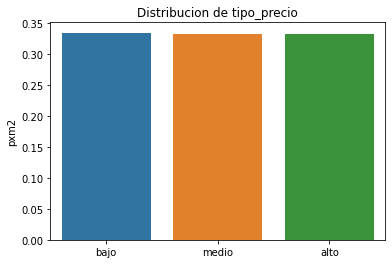

In [153]:
quantiles = pd.qcut(df['pxm2'], 3)
ax = sns.barplot(data=df, x=['bajo', 'medio', 'alto'], y=frec_relativa(quantiles))
ax.set(title='Distribucion de tipo_precio')


### Alternativa 2

Separamos en 3 intervalos, el primero con 25% de las obs., el segundo con 50% y el tercero con 25%

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=93b86fc9-77e6-4ecc-8d2c-ef4e6ae5be5f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>